In [1]:
import numpy as np
import matplotlib.pyplot as plt


# from hnc_custom_screeningOZ_multiscale import  HNC_solver
from hnc import  HNC_solver
from qsps import *

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
N_bins, R_max = 1000, 10

In [3]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, tol=1e-8, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='best', add_bridge=False, bridge='yukawa' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=tol,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp

In [4]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' ,oz_type='standard', which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3,oz_method=oz_type)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



In [5]:
def run_hnc_TF(n_in_per_cc, T, Z, A, Zstar,κ = 1, num_iterations=1e3, alpha = 1e-3,method='best',oz_type='standard', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
#     hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
#                      kappa_multiscale=1, num_iterations=int(num_iterations), 
#                      R_max=5, N_bins=N_bins, names=names, dst_type=3)
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=R_max, N_bins=N_bins, names=names, dst_type=3, oz_method=oz_type)

    βu_r_matrix = np.array([[ qsp.Γii/hnc1.r_array *np.exp(-κ*hnc1.r_array)  ]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp


In [6]:
def get_κ(Zstar, ri, Ti, E_F):
    kTF = np.sqrt(  4*π* Zstar*QSP_HNC.n_from_rs(ri)  /np.sqrt(Ti**2 + (2/3*E_F)**2)  )
    return kTF*ri


# Carbon

"Theory of complex fluids in the warm dense matter regime andapplication to an unusual phase transition in liquid carbon"
M.W.C. Dharma-wardana

In [7]:
ri = 1.36
case = 1
ni = QSP_HNC.n_from_rs(ri)/aB**3*1e-6
Te = [8.62*eV, 21.5*eV, 430.9*eV][case]
Ti = [8.62*eV, 21.5*eV, 430.9*eV][case]
Z, A = 6,12
Zstar= [4, 4, 5.758][case]


In [8]:
carbon, carbonqsp = run_hnc(ni, Te, Z, A, Zstar , tol=1e-6, method='best', alpha=1e-1, num_iterations=1e3)

Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 5.56e+00, OZ: 1.48e-01, HNC: 1.17e+04, tot: 5.00e+01, tot: 5.03e+01
1: Err in c_r: 5.03e+00, OZ: 1.45e-01, HNC: 2.17e+03, tot: 4.53e+01, tot: 4.56e+01
HNC αs: [0.6 0.2 0.1], c_err: 1.79213e+03 
HNC αs: [0.63 0.2  0.1 ], c_err: 2.50285e+03 
HNC αs: [0.6  0.21 0.1 ], c_err: 2.00336e+03 
HNC αs: [0.6   0.2   0.105], c_err: 1.89504e+03 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 1.43672e+03 
HNC αs: [0.54  0.21  0.105], c_err: 1.09105e+03 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 1.19540e+03 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 9.30958e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 6.55127e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 5.06001e+02 
HNC αs: [0.4        0.21333333 0.11333333], c_err: 2.72674e+02 
HNC αs: [0.4        0.22333333 0.10666667], c_err: 2.82475e+02 
HNC αs: [0.32666667 0.21888889 0.10944444], c_err

HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
HNC αs: [0.         0.         0.00136533], c_err: 1.17434e+00 
HNC αs: [0.         0.         0.00227555], c_err: 1.18737e+00 
HNC αs: [0.         0.         0.00170666], c_err: 1.17916e+00 
HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
HNC αs: [0. 0. 0.], c_err: 1.15600e+00 
 HNC min: [0. 0. 0.] True Optimization terminated successfully.
3: Err in c_r: 2.88e+00, OZ: 5.13e-16, HNC: 2.33e-15, tot: 1.81e-16, tot: 1.16e+00
HNC αs: [0.6 0.2 0.1], c_err: 1.15491e+03 
HNC αs: [0.63 0.2  0.1 ], c_err: 1.58161e+03 
HNC αs: [0.6  0.21 0.1 ], c_err: 1.28521e+03 
HNC αs: [0.6   0.2   0.105], c_err: 1.21904e+03 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 9.39872e+02 
HNC αs: [0.54  0.21  0.105], c_err: 7.25796e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 7.89543e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 6.23935e+

HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.09176e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.08415e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.90379e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.22111e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.80774e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.49305e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.76831e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.15266e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81430e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.59856e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34191e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53758e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.38936e+00 
HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.01382e+00 
HNC αs: [0.02592593 0.00111111 0.        ], c_err: 8.30520e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 4.32658

HNC αs: [0.         0.00099704 0.        ], c_err: 2.85568e-01 
HNC αs: [0.         0.00103705 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00100185 0.        ], c_err: 2.85568e-01 
HNC αs: [0.         0.00103209 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00104512 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00102041 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00100915 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00103008 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00103825 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00102216 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00103581 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00102426 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00101891 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00102879 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00103326 0.        ], c_err: 2.85567e-01 
HNC αs: [0.         0.00102494 0.       

HNC αs: [0.54  0.21  0.105], c_err: 3.32565e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 3.58320e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 2.91244e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 2.17700e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.76161e+02 
HNC αs: [0.4        0.21333333 0.11333333], c_err: 1.06083e+02 
HNC αs: [0.4        0.22333333 0.10666667], c_err: 1.09147e+02 
HNC αs: [0.32666667 0.21888889 0.10944444], c_err: 5.79991e+01 
HNC αs: [0.22       0.22333333 0.11166667], c_err: 2.76758e+01 
HNC αs: [0.18       0.23333333 0.11944444], c_err: 2.40850e+01 
HNC αs: [0.02       0.24666667 0.12833333], c_err: 1.24059e+01 
HNC αs: [0.02666667 0.23222222 0.12888889], c_err: 1.20632e+01 
HNC αs: [0.         0.23666667 0.14      ], c_err: 1.15683e+01 
HNC αs: [0.         0.25777778 0.14      ], c_err: 1.25468e+01 
HNC αs: [0.         0.27074074 0.16055556], c_err: 1.43961e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.30

HNC αs: [0.02592593 0.00111111 0.        ], c_err: 7.48111e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 1.05058e-01 
HNC αs: [0.         0.00222222 0.        ], c_err: 1.12775e-01 
HNC αs: [0.         0.00061728 0.        ], c_err: 1.00739e-01 
HNC αs: [0.         0.00037037 0.        ], c_err: 1.00532e-01 
HNC αs: [0.         0.00197531 0.        ], c_err: 1.09834e-01 
HNC αs: [0.         0.00144033 0.        ], c_err: 1.04731e-01 
HNC αs: [0.         0.00021948 0.        ], c_err: 1.00635e-01 
HNC αs: [0. 0. 0.], c_err: 1.01097e-01 
HNC αs: [0. 0. 0.], c_err: 1.01097e-01 
HNC αs: [0. 0. 0.], c_err: 1.01097e-01 
HNC αs: [0.         0.00039323 0.        ], c_err: 1.00531e-01 
HNC αs: [0.         0.00058985 0.        ], c_err: 1.00693e-01 
HNC αs: [0.         0.00065539 0.        ], c_err: 1.00813e-01 
HNC αs: [0.         0.00049154 0.        ], c_err: 1.00575e-01 
HNC αs: [0.         0.00061728 0.        ], c_err: 1.00739e-01 
HNC αs: [0.         0.00031893 0.        ], c_er

HNC αs: [0.         0.00027845 0.        ], c_err: 7.27286e-02 
HNC αs: [0.         0.00028061 0.        ], c_err: 7.27286e-02 
HNC αs: [0.         0.00028147 0.        ], c_err: 7.27286e-02 
HNC αs: [0.         0.00027979 0.        ], c_err: 7.27286e-02 
HNC αs: [0.         0.00027906 0.        ], c_err: 7.27286e-02 
HNC αs: [0.         0.00028044 0.        ], c_err: 7.27286e-02 
 HNC min: [0.         0.00028044 0.        ] True Optimization terminated successfully.
10: Err in c_r: 9.96e-02, OZ: 7.77e-03, HNC: 5.44e-02, tot: 7.76e-03, tot: 7.27e-02
HNC αs: [0.6 0.2 0.1], c_err: 3.75793e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 4.89713e+02 
HNC αs: [0.6  0.21 0.1 ], c_err: 4.10661e+02 
HNC αs: [0.6   0.2   0.105], c_err: 3.92988e+02 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 3.15554e+02 
HNC αs: [0.54  0.21  0.105], c_err: 2.53769e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 2.72724e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 2.23701e+02 
HNC αs: [0.5       

HNC αs: [0.         0.00197531 0.        ], c_err: 6.44052e-02 
HNC αs: [0.         0.00144033 0.        ], c_err: 5.35224e-02 
HNC αs: [0.         0.00021948 0.        ], c_err: 3.99285e-02 
HNC αs: [0. 0. 0.], c_err: 4.01306e-02 
HNC αs: [0. 0. 0.], c_err: 4.01306e-02 
HNC αs: [0. 0. 0.], c_err: 4.01306e-02 
HNC αs: [0. 0. 0.], c_err: 4.01306e-02 
HNC αs: [0. 0. 0.], c_err: 4.01306e-02 
HNC αs: [0.         0.00014632 0.        ], c_err: 3.98923e-02 
HNC αs: [0.         0.00021948 0.        ], c_err: 3.99285e-02 
HNC αs: [0.         0.00024387 0.        ], c_err: 3.99636e-02 
HNC αs: [0.         0.00040644 0.        ], c_err: 4.04882e-02 
HNC αs: [0.         0.00010161 0.        ], c_err: 3.99213e-02 
HNC αs: [0.00000000e+00 6.77403512e-05 0.00000000e+00], c_err: 3.99690e-02 
HNC αs: [0.         0.00019983 0.        ], c_err: 3.99086e-02 
HNC αs: [0.00000000e+00 7.90304098e-05 0.00000000e+00], c_err: 3.99506e-02 
HNC αs: [0.         0.00018437 0.        ], c_err: 3.98982e-02 
HNC αs: 

HNC αs: [0.        0.0001196 0.       ], c_err: 2.97855e-02 
HNC αs: [0.         0.00011762 0.        ], c_err: 2.97855e-02 
HNC αs: [0.        0.0001167 0.       ], c_err: 2.97855e-02 
HNC αs: [0.        0.0001184 0.       ], c_err: 2.97855e-02 
 HNC min: [0.         0.00011762 0.        ] True Optimization terminated successfully.
13: Err in c_r: 3.95e-02, OZ: 3.26e-03, HNC: 2.30e-02, tot: 3.25e-03, tot: 2.98e-02
HNC αs: [0.6 0.2 0.1], c_err: 3.31455e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 4.29775e+02 
HNC αs: [0.6  0.21 0.1 ], c_err: 3.61469e+02 
HNC αs: [0.6   0.2   0.105], c_err: 3.46191e+02 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 2.79130e+02 
HNC αs: [0.54  0.21  0.105], c_err: 2.25397e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 2.41961e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 1.99270e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 1.51822e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.24459e+02 
HNC αs: [0.4        0.213333

HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81793e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60027e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34751e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53812e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39126e+00 
HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.00696e+00 
HNC αs: [0.02592593 0.00111111 0.        ], c_err: 7.51087e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 4.17085e-02 
HNC αs: [0.         0.00222222 0.        ], c_err: 6.16914e-02 
HNC αs: [0.         0.00061728 0.        ], c_err: 2.00578e-02 
HNC αs: [0.         0.00037037 0.        ], c_err: 1.52491e-02 
HNC αs: [0.         0.00197531 0.        ], c_err: 5.49793e-02 
HNC αs: [0.         0.00144033 0.        ], c_err: 4.06166e-02 
HNC αs: [0.         0.00021948 0.        ], c_err: 1.32375e-02 
HNC αs: [0. 0. 0.], c_err: 1.24410e-02 
HNC αs: [0. 0. 0.], c_err: 1.24410e-02 
HNC αs: [0. 0. 0.], c_err: 1.24410e-02 
HN

HNC αs: [0.         0.27074074 0.16055556], c_err: 1.35692e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24647e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10663e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04307e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03716e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60805e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.03063e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75809e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.45039e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.77610e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.17599e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81884e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60119e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34837e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53877e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39194

HNC αs: [0.5        0.20666667 0.10166667], c_err: 1.40812e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.15757e+02 
HNC αs: [0.4        0.21333333 0.11333333], c_err: 7.29879e+01 
HNC αs: [0.4        0.22333333 0.10666667], c_err: 7.49091e+01 
HNC αs: [0.32666667 0.21888889 0.10944444], c_err: 4.28519e+01 
HNC αs: [0.22       0.22333333 0.11166667], c_err: 2.30850e+01 
HNC αs: [0.18       0.23333333 0.11944444], c_err: 2.06205e+01 
HNC αs: [0.02       0.24666667 0.12833333], c_err: 1.19404e+01 
HNC αs: [0.02666667 0.23222222 0.12888889], c_err: 1.16504e+01 
HNC αs: [0.         0.23666667 0.14      ], c_err: 1.12198e+01 
HNC αs: [0.         0.25777778 0.14      ], c_err: 1.20543e+01 
HNC αs: [0.         0.27074074 0.16055556], c_err: 1.35504e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24519e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10591e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04255e+01 
HNC αs: [0.02666667 0.21333333 0.1133333

HNC αs: [0.6 0.2 0.1], c_err: 3.02359e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 3.90613e+02 
HNC αs: [0.6  0.21 0.1 ], c_err: 3.29245e+02 
HNC αs: [0.6   0.2   0.105], c_err: 3.15511e+02 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 2.55167e+02 
HNC αs: [0.54  0.21  0.105], c_err: 2.06668e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 2.21672e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 1.83107e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 1.40119e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.15209e+02 
HNC αs: [0.4        0.21333333 0.11333333], c_err: 7.26829e+01 
HNC αs: [0.4        0.22333333 0.10666667], c_err: 7.45940e+01 
HNC αs: [0.32666667 0.21888889 0.10944444], c_err: 4.27106e+01 
HNC αs: [0.22       0.22333333 0.11166667], c_err: 2.30420e+01 
HNC αs: [0.18       0.23333333 0.11944444], c_err: 2.05881e+01 
HNC αs: [0.02       0.24666667 0.12833333], c_err: 1.19360e+01 
HNC αs: [0.02666667 0.23222222 0.12888889], c_err: 1.16465e+01 

HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.00847e+00 
HNC αs: [0.02592593 0.00111111 0.        ], c_err: 7.52435e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 4.11648e-02 
HNC αs: [0.         0.00222222 0.        ], c_err: 6.17741e-02 
HNC αs: [0.         0.00061728 0.        ], c_err: 1.71243e-02 
HNC αs: [0.         0.00037037 0.        ], c_err: 1.02597e-02 
HNC αs: [0.         0.00197531 0.        ], c_err: 5.49042e-02 
HNC αs: [0.         0.00144033 0.        ], c_err: 4.00198e-02 
HNC αs: [0.         0.00021948 0.        ], c_err: 6.07071e-03 
HNC αs: [0. 0. 0.], c_err: 5.29421e-04 
HNC αs: [0. 0. 0.], c_err: 5.29421e-04 
HNC αs: [0. 0. 0.], c_err: 5.29421e-04 
HNC αs: [0. 0. 0.], c_err: 5.29421e-04 
HNC αs: [0. 0. 0.], c_err: 5.29421e-04 
 HNC min: [0. 0. 0.] True Optimization terminated successfully.
27: Err in c_r: 7.02e-04, OZ: 2.92e-16, HNC: 1.17e-14, tot: 1.37e-16, tot: 5.29e-04
HNC αs: [0.6 0.2 0.1], c_err: 3.01632e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 

HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03631e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60240e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.02655e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75644e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.44917e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.77618e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.17631e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81948e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60183e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34898e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53922e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39242e+00 
HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.00851e+00 
HNC αs: [0.02592593 0.00111111 0.        ], c_err: 7.52472e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 4.11962e-02 
HNC αs: [0.         0.00222222 0.        ], c_err: 6.18066

HNC αs: [0.         0.27074074 0.16055556], c_err: 1.35371e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24428e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10541e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04217e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03629e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60225e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.02644e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75640e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.44914e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.77618e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.17632e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81949e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60184e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34900e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53923e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39243

HNC αs: [0.32666667 0.21888889 0.10944444], c_err: 4.26107e+01 
HNC αs: [0.22       0.22333333 0.11166667], c_err: 2.30116e+01 
HNC αs: [0.18       0.23333333 0.11944444], c_err: 2.05651e+01 
HNC αs: [0.02       0.24666667 0.12833333], c_err: 1.19329e+01 
HNC αs: [0.02666667 0.23222222 0.12888889], c_err: 1.16437e+01 
HNC αs: [0.         0.23666667 0.14      ], c_err: 1.12142e+01 
HNC αs: [0.         0.25777778 0.14      ], c_err: 1.20464e+01 
HNC αs: [0.         0.27074074 0.16055556], c_err: 1.35368e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24426e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10540e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04216e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03628e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60219e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.02640e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75638e+00 
HNC αs: [0.05333333 0.14481481 0.0644444

HNC αs: [0.6 0.2 0.1], c_err: 3.01117e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 3.88944e+02 
HNC αs: [0.6  0.21 0.1 ], c_err: 3.27870e+02 
HNC αs: [0.6   0.2   0.105], c_err: 3.14201e+02 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 2.54143e+02 
HNC αs: [0.54  0.21  0.105], c_err: 2.05867e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 2.20803e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 1.82414e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 1.39617e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.14812e+02 
HNC αs: [0.4        0.21333333 0.11333333], c_err: 7.24617e+01 
HNC αs: [0.4        0.22333333 0.10666667], c_err: 7.43654e+01 
HNC αs: [0.32666667 0.21888889 0.10944444], c_err: 4.26081e+01 
HNC αs: [0.22       0.22333333 0.11166667], c_err: 2.30108e+01 
HNC αs: [0.18       0.23333333 0.11944444], c_err: 2.05645e+01 
HNC αs: [0.02       0.24666667 0.12833333], c_err: 1.19328e+01 
HNC αs: [0.02666667 0.23222222 0.12888889], c_err: 1.16436e+01 

HNC αs: [0.         0.00021948 0.        ], c_err: 6.10559e-03 
HNC αs: [0. 0. 0.], c_err: 9.91172e-06 
HNC αs: [0. 0. 0.], c_err: 9.91172e-06 
HNC αs: [0. 0. 0.], c_err: 9.91172e-06 
HNC αs: [0. 0. 0.], c_err: 9.91172e-06 
HNC αs: [0. 0. 0.], c_err: 9.91172e-06 
 HNC min: [0. 0. 0.] True Optimization terminated successfully.
41: Err in c_r: 1.33e-05, OZ: 5.28e-16, HNC: 1.28e-14, tot: 1.85e-16, tot: 9.91e-06
HNC αs: [0.6 0.2 0.1], c_err: 3.01103e+02 
HNC αs: [0.63 0.2  0.1 ], c_err: 3.88925e+02 
HNC αs: [0.6  0.21 0.1 ], c_err: 3.27855e+02 
HNC αs: [0.6   0.2   0.105], c_err: 3.14187e+02 
HNC αs: [0.57       0.20666667 0.10333333], c_err: 2.54132e+02 
HNC αs: [0.54  0.21  0.105], c_err: 2.05858e+02 
HNC αs: [0.56       0.19666667 0.10666667], c_err: 2.20794e+02 
HNC αs: [0.53333333 0.20444444 0.10277778], c_err: 1.82407e+02 
HNC αs: [0.5        0.20666667 0.10166667], c_err: 1.39611e+02 
HNC αs: [0.46666667 0.20888889 0.10888889], c_err: 1.14807e+02 
HNC αs: [0.4        0.21333333 0.11

HNC αs: [0.09333333 0.         0.        ], c_err: 2.60186e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34901e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53924e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39244e+00 
HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.00854e+00 
HNC αs: [0.02592593 0.00111111 0.        ], c_err: 7.52499e-01 
HNC αs: [0.         0.00148148 0.        ], c_err: 4.12201e-02 
HNC αs: [0.         0.00222222 0.        ], c_err: 6.18308e-02 
HNC αs: [0.         0.00061728 0.        ], c_err: 1.71746e-02 
HNC αs: [0.         0.00037037 0.        ], c_err: 1.03046e-02 
HNC αs: [0.         0.00197531 0.        ], c_err: 5.49605e-02 
HNC αs: [0.         0.00144033 0.        ], c_err: 4.00751e-02 
HNC αs: [0.         0.00021948 0.        ], c_err: 6.10621e-03 
HNC αs: [0. 0. 0.], c_err: 4.27517e-06 
HNC αs: [0. 0. 0.], c_err: 4.27517e-06 
HNC αs: [0. 0. 0.], c_err: 4.27517e-06 
HNC αs: [0. 0. 0.], c_err: 4.27517e-06 
HNC αs: [0. 0. 0.], c_err:

HNC αs: [0.         0.27074074 0.16055556], c_err: 1.35365e+01 
HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24424e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10539e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04216e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03627e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60215e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.02636e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75637e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.44912e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.77619e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.17632e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81951e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60186e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34901e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53924e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39244

HNC αs: [0.         0.25888889 0.14833333], c_err: 1.24424e+01 
HNC αs: [0.01333333 0.23518519 0.12388889], c_err: 1.10539e+01 
HNC αs: [0.02       0.22333333 0.11166667], c_err: 1.04216e+01 
HNC αs: [0.02666667 0.21333333 0.11333333], c_err: 1.03627e+01 
HNC αs: [0.04       0.19111111 0.1       ], c_err: 9.60215e+00 
HNC αs: [0.02       0.18740741 0.10611111], c_err: 9.02636e+00 
HNC αs: [0.02       0.15777778 0.095     ], c_err: 7.75637e+00 
HNC αs: [0.05333333 0.14481481 0.06444444], c_err: 7.44912e+00 
HNC αs: [0.08       0.09888889 0.02666667], c_err: 5.77619e+00 
HNC αs: [0.07333333 0.07518519 0.03611111], c_err: 5.17632e+00 
HNC αs: [0.1        0.00111111 0.        ], c_err: 2.81951e+00 
HNC αs: [0.09333333 0.         0.        ], c_err: 2.60186e+00 
HNC αs: [0.12 0.   0.  ], c_err: 3.34901e+00 
HNC αs: [0.16222222 0.         0.        ], c_err: 4.53924e+00 
HNC αs: [0.15703704 0.         0.        ], c_err: 4.39244e+00 
HNC αs: [0.07135802 0.00074074 0.        ], c_err: 2.00854

In [8]:
carbonSVT, carbonqsp = run_hnc(ni, Te, Z, A, Zstar , which_Tij='thermal', oz_type='svt',method='best', tol=1e-6, alpha=1e-1, num_iterations=1e1)

Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 5.56e+00, OZ: 1.45e-01, HNC: 1.97e+04, tot: 5.00e+01, tot: 5.03e+01
1: Err in c_r: 5.03e+00, OZ: 1.42e-01, HNC: 3.19e+03, tot: 4.53e+01, tot: 4.56e+01
HNC αs: [1. 0. 0.], c_err: 5.71202e+03 
HNC αs: [1. 0. 0.], c_err: 5.71202e+03 
HNC αs: [1.0e+00 2.5e-04 0.0e+00], c_err: 5.72827e+03 
HNC αs: [1.0e+00 0.0e+00 2.5e-04], c_err: 5.72832e+03 
HNC αs: [1.00000000e+00 1.66666667e-04 0.00000000e+00], c_err: 5.72285e+03 
HNC αs: [1. 0. 0.], c_err: 5.71202e+03 
HNC αs: [1. 0. 0.], c_err: 5.71202e+03 
HNC αs: [1. 0. 0.], c_err: 5.71202e+03 
 HNC min: [1. 0. 0.] True Optimization terminated successfully.
2: Err in c_r: 2.76e+01, OZ: 2.77e+01, HNC: 2.08e+75, tot: 2.83e+01, tot: 5.71e+03
HNC αs: [1. 0. 0.], c_err: 4.43316e+08 
HNC αs: [1. 0. 0.], c_err: 4.43316e+08 
HNC αs: [1.0e+00 2.5e-04 0.0e+00], c_err: 3.10931e+12 
HNC αs: [1.0e+00 0.0e+00 2.5e-04], c_err: 3.10942e+12 
HNC αs:

/home/zach/plasma/hnc/hnc.py:441: RuntimeWarning: overflow encountered in exp
  hnc_err = np.linalg.norm(- 1 - self.h_r_matrix   + np.exp( -self.βu_r_matrix + self.h_r_matrix - self.c_r_matrix ))/np.sqrt(self.N_bins*self.N_species**2)


3: Err in c_r: 2.76e+01, OZ: 4.67e+03, HNC: inf, tot: 5.71e+03, tot: 4.43e+08
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1.0e+00 2.5e-04 0.0e+00], c_err: inf 
HNC αs: [1.0e+00 0.0e+00 2.5e-04], c_err: inf 
HNC αs: [1.00000000e+00 1.66666667e-04 0.00000000e+00], c_err: inf 


/home/zach/plasma/hnc/hnc.py:362: RuntimeWarning: overflow encountered in exp
  tot_eqn =  1 + h_r_matrix  - np.exp(-self.βu_s_r_matrix + h_r_matrix - c_s_r_matrix )


HNC αs: [1.00000000e+00 4.16666667e-05 1.25000000e-04], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1.00e+00 1.25e-04 0.00e+00], c_err: inf 
HNC αs: [1.00e+00 0.00e+00 1.25e-04], c_err: inf 
HNC αs: [1.00000000e+00 8.33333333e-05 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 2.08333333e-05 6.25000000e-05], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1.00e+00 6.25e-05 0.00e+00], c_err: inf 
HNC αs: [1.00e+00 0.00e+00 6.25e-05], c_err: inf 
HNC αs: [1.00000000e+00 4.16666667e-05 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 1.04166667e-05 3.12500000e-05], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1.000e+00 3.125e-05 0.000e+00], c_err: inf 
HNC αs: [1.000e+00 0.000e+00 3.125e-05], c_err: inf 
HNC αs: [1.00000000e+00 2.08333333e-05 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 5.20833333e-06 1.56250000e-05], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 5.07464e+13 
HNC αs: [1.0000e+00 1.5625e-05 0.0000e+00], c_err: inf 
HN

HNC αs: [1.00000000e+00 2.60416667e-06 7.81250000e-06], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 2.37734e+29 
HNC αs: [1.0000e+00 7.8125e-06 0.0000e+00], c_err: inf 
HNC αs: [1.0000e+00 0.0000e+00 7.8125e-06], c_err: inf 
HNC αs: [1.00000000e+00 5.20833333e-06 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 1.30208333e-06 3.90625000e-06], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 2.37734e+29 
HNC αs: [1.00000e+00 3.90625e-06 0.00000e+00], c_err: inf 
HNC αs: [1.00000e+00 0.00000e+00 3.90625e-06], c_err: inf 
HNC αs: [1.00000000e+00 2.60416667e-06 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 6.51041667e-07 1.95312500e-06], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 2.37734e+29 
HNC αs: [1.000000e+00 1.953125e-06 0.000000e+00], c_err: inf 
HNC αs: [1.000000e+00 0.000000e+00 1.953125e-06], c_err: inf 
HNC αs: [1.00000000e+00 1.30208333e-06 0.00000000e+00], c_err: inf 
HNC αs: [1.00000000e+00 3.25520833e-07 9.76562500e-07], c_err: inf 
HNC αs: [1. 0. 0.], c_err: 2.37734e+29 
HNC αs: [1

In [ ]:
"12: Err in c_r: 3.50e-06, OZ: 1.04e-02, HNC: 5.71e-01, tot: 3.50e-02, tot: 3.50e-02"


In [22]:
carbonSVT_OCPBridge, carbonqsp = run_hnc(ni, Te, Z, A, Zstar , which_Tij='thermal', oz_type='svt',method='fixed', tol=1e-6, alpha=1e-1, num_iterations=1e4, add_bridge=True, bridge='ocp')


Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 5.56e+00, OZ: 1.46e-01, HNC: 1.65e+04, tot: 5.00e+01, tot: 5.03e+01
1: Err in c_r: 5.03e+00, OZ: 1.43e-01, HNC: 2.80e+03, tot: 4.53e+01, tot: 4.56e+01
2: Err in c_r: 4.56e+00, OZ: 1.40e-01, HNC: 7.96e+02, tot: 4.10e+01, tot: 4.12e+01
3: Err in c_r: 4.12e+00, OZ: 1.38e-01, HNC: 3.21e+02, tot: 3.71e+01, tot: 3.73e+01
4: Err in c_r: 3.73e+00, OZ: 1.35e-01, HNC: 1.66e+02, tot: 3.36e+01, tot: 3.38e+01
5: Err in c_r: 3.38e+00, OZ: 1.32e-01, HNC: 1.04e+02, tot: 3.04e+01, tot: 3.06e+01
6: Err in c_r: 3.06e+00, OZ: 1.30e-01, HNC: 7.44e+01, tot: 2.75e+01, tot: 2.77e+01
7: Err in c_r: 2.77e+00, OZ: 1.27e-01, HNC: 5.93e+01, tot: 2.49e+01, tot: 2.51e+01
8: Err in c_r: 2.50e+00, OZ: 1.25e-01, HNC: 5.13e+01, tot: 2.25e+01, tot: 2.27e+01
9: Err in c_r: 2.27e+00, OZ: 1.23e-01, HNC: 4.75e+01, tot: 2.04e+01, tot: 2.05e+01
10: Err in c_r: 2.05e+00, OZ: 1.20e-01, HNC: 4.62e+01, tot: 1.85e+

97: Err in c_r: 3.38e-03, OZ: 1.27e-02, HNC: 7.39e-01, tot: 3.04e-02, tot: 1.57e+00
98: Err in c_r: 3.21e-03, OZ: 1.23e-02, HNC: 6.70e-01, tot: 2.89e-02, tot: 1.57e+00
99: Err in c_r: 3.05e-03, OZ: 1.19e-02, HNC: 6.13e-01, tot: 2.75e-02, tot: 1.57e+00
100: Err in c_r: 2.91e-03, OZ: 1.16e-02, HNC: 5.64e-01, tot: 2.62e-02, tot: 1.57e+00
101: Err in c_r: 2.78e-03, OZ: 1.12e-02, HNC: 5.24e-01, tot: 2.51e-02, tot: 1.57e+00
102: Err in c_r: 2.67e-03, OZ: 1.08e-02, HNC: 4.92e-01, tot: 2.40e-02, tot: 1.57e+00
103: Err in c_r: 2.56e-03, OZ: 1.05e-02, HNC: 4.65e-01, tot: 2.31e-02, tot: 1.57e+00
104: Err in c_r: 2.47e-03, OZ: 1.01e-02, HNC: 4.44e-01, tot: 2.22e-02, tot: 1.57e+00
105: Err in c_r: 2.38e-03, OZ: 9.80e-03, HNC: 4.28e-01, tot: 2.15e-02, tot: 1.57e+00
106: Err in c_r: 2.30e-03, OZ: 9.49e-03, HNC: 4.15e-01, tot: 2.07e-02, tot: 1.57e+00
107: Err in c_r: 2.23e-03, OZ: 9.18e-03, HNC: 4.06e-01, tot: 2.01e-02, tot: 1.57e+00
108: Err in c_r: 2.17e-03, OZ: 8.88e-03, HNC: 3.99e-01, tot: 1.95e-0

194: Err in c_r: 1.17e-04, OZ: 4.54e-04, HNC: 2.80e-02, tot: 1.06e-03, tot: 1.58e+00
195: Err in c_r: 1.13e-04, OZ: 4.38e-04, HNC: 2.70e-02, tot: 1.02e-03, tot: 1.58e+00
196: Err in c_r: 1.09e-04, OZ: 4.23e-04, HNC: 2.59e-02, tot: 9.81e-04, tot: 1.58e+00
197: Err in c_r: 1.05e-04, OZ: 4.09e-04, HNC: 2.49e-02, tot: 9.45e-04, tot: 1.58e+00
198: Err in c_r: 1.01e-04, OZ: 3.94e-04, HNC: 2.39e-02, tot: 9.10e-04, tot: 1.58e+00
199: Err in c_r: 9.74e-05, OZ: 3.81e-04, HNC: 2.30e-02, tot: 8.77e-04, tot: 1.58e+00
200: Err in c_r: 9.38e-05, OZ: 3.68e-04, HNC: 2.21e-02, tot: 8.45e-04, tot: 1.58e+00
201: Err in c_r: 9.04e-05, OZ: 3.55e-04, HNC: 2.12e-02, tot: 8.13e-04, tot: 1.58e+00
202: Err in c_r: 8.71e-05, OZ: 3.43e-04, HNC: 2.04e-02, tot: 7.84e-04, tot: 1.58e+00
203: Err in c_r: 8.39e-05, OZ: 3.31e-04, HNC: 1.96e-02, tot: 7.55e-04, tot: 1.58e+00
204: Err in c_r: 8.08e-05, OZ: 3.20e-04, HNC: 1.88e-02, tot: 7.27e-04, tot: 1.58e+00
205: Err in c_r: 7.78e-05, OZ: 3.09e-04, HNC: 1.81e-02, tot: 7.00

291: Err in c_r: 3.81e-06, OZ: 1.51e-05, HNC: 8.84e-04, tot: 3.43e-05, tot: 1.58e+00
292: Err in c_r: 3.68e-06, OZ: 1.46e-05, HNC: 8.54e-04, tot: 3.31e-05, tot: 1.58e+00
293: Err in c_r: 3.55e-06, OZ: 1.41e-05, HNC: 8.25e-04, tot: 3.20e-05, tot: 1.58e+00
294: Err in c_r: 3.43e-06, OZ: 1.36e-05, HNC: 7.97e-04, tot: 3.09e-05, tot: 1.58e+00
295: Err in c_r: 3.31e-06, OZ: 1.31e-05, HNC: 7.70e-04, tot: 2.98e-05, tot: 1.58e+00
296: Err in c_r: 3.20e-06, OZ: 1.27e-05, HNC: 7.43e-04, tot: 2.88e-05, tot: 1.58e+00
297: Err in c_r: 3.09e-06, OZ: 1.22e-05, HNC: 7.18e-04, tot: 2.78e-05, tot: 1.58e+00
298: Err in c_r: 2.98e-06, OZ: 1.18e-05, HNC: 6.93e-04, tot: 2.68e-05, tot: 1.58e+00
299: Err in c_r: 2.88e-06, OZ: 1.14e-05, HNC: 6.70e-04, tot: 2.59e-05, tot: 1.58e+00
300: Err in c_r: 2.78e-06, OZ: 1.10e-05, HNC: 6.47e-04, tot: 2.50e-05, tot: 1.58e+00
301: Err in c_r: 2.68e-06, OZ: 1.06e-05, HNC: 6.24e-04, tot: 2.42e-05, tot: 1.58e+00
302: Err in c_r: 2.59e-06, OZ: 1.03e-05, HNC: 6.03e-04, tot: 2.33

In [23]:
carbonSVT_YukBridge, carbonqsp = run_hnc(ni, Te, Z, A, Zstar , which_Tij='thermal', oz_type='svt',method='fixed', tol=1e-6, alpha=1e-1, num_iterations=1e4, add_bridge=True, bridge='yukawa')

Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 5.56e+00, OZ: 1.46e-01, HNC: 1.85e+04, tot: 5.00e+01, tot: 5.03e+01
1: Err in c_r: 5.03e+00, OZ: 1.43e-01, HNC: 3.05e+03, tot: 4.53e+01, tot: 4.56e+01
2: Err in c_r: 4.56e+00, OZ: 1.40e-01, HNC: 8.49e+02, tot: 4.10e+01, tot: 4.12e+01
3: Err in c_r: 4.12e+00, OZ: 1.37e-01, HNC: 3.38e+02, tot: 3.71e+01, tot: 3.73e+01
4: Err in c_r: 3.73e+00, OZ: 1.34e-01, HNC: 1.74e+02, tot: 3.36e+01, tot: 3.38e+01
5: Err in c_r: 3.38e+00, OZ: 1.32e-01, HNC: 1.08e+02, tot: 3.04e+01, tot: 3.06e+01
6: Err in c_r: 3.06e+00, OZ: 1.29e-01, HNC: 7.72e+01, tot: 2.75e+01, tot: 2.77e+01
7: Err in c_r: 2.77e+00, OZ: 1.27e-01, HNC: 6.14e+01, tot: 2.49e+01, tot: 2.51e+01
8: Err in c_r: 2.50e+00, OZ: 1.24e-01, HNC: 5.32e+01, tot: 2.25e+01, tot: 2.27e+01
9: Err in c_r: 2.27e+00, OZ: 1.22e-01, HNC: 4.92e+01, tot: 2.04e+01, tot: 2.05e+01
10: Err in c_r: 2.05e+00, OZ: 1.20e-01, HNC: 4.79e+01, tot: 1.84e+

97: Err in c_r: 2.68e-03, OZ: 1.06e-02, HNC: 4.64e-01, tot: 2.41e-02, tot: 1.57e+00
98: Err in c_r: 2.53e-03, OZ: 1.03e-02, HNC: 4.06e-01, tot: 2.27e-02, tot: 1.57e+00
99: Err in c_r: 2.39e-03, OZ: 9.90e-03, HNC: 3.59e-01, tot: 2.15e-02, tot: 1.57e+00
100: Err in c_r: 2.27e-03, OZ: 9.55e-03, HNC: 3.21e-01, tot: 2.04e-02, tot: 1.57e+00
101: Err in c_r: 2.16e-03, OZ: 9.22e-03, HNC: 2.91e-01, tot: 1.94e-02, tot: 1.57e+00
102: Err in c_r: 2.06e-03, OZ: 8.89e-03, HNC: 2.69e-01, tot: 1.86e-02, tot: 1.57e+00
103: Err in c_r: 1.98e-03, OZ: 8.58e-03, HNC: 2.53e-01, tot: 1.78e-02, tot: 1.57e+00
104: Err in c_r: 1.90e-03, OZ: 8.27e-03, HNC: 2.41e-01, tot: 1.71e-02, tot: 1.57e+00
105: Err in c_r: 1.83e-03, OZ: 7.98e-03, HNC: 2.35e-01, tot: 1.65e-02, tot: 1.57e+00
106: Err in c_r: 1.76e-03, OZ: 7.70e-03, HNC: 2.32e-01, tot: 1.59e-02, tot: 1.58e+00
107: Err in c_r: 1.71e-03, OZ: 7.43e-03, HNC: 2.32e-01, tot: 1.54e-02, tot: 1.58e+00
108: Err in c_r: 1.66e-03, OZ: 7.16e-03, HNC: 2.34e-01, tot: 1.49e-0

194: Err in c_r: 7.30e-05, OZ: 2.69e-04, HNC: 1.80e-02, tot: 6.57e-04, tot: 1.58e+00
195: Err in c_r: 6.99e-05, OZ: 2.59e-04, HNC: 1.72e-02, tot: 6.29e-04, tot: 1.58e+00
196: Err in c_r: 6.69e-05, OZ: 2.49e-04, HNC: 1.64e-02, tot: 6.03e-04, tot: 1.58e+00
197: Err in c_r: 6.41e-05, OZ: 2.40e-04, HNC: 1.56e-02, tot: 5.77e-04, tot: 1.58e+00
198: Err in c_r: 6.13e-05, OZ: 2.30e-04, HNC: 1.49e-02, tot: 5.52e-04, tot: 1.58e+00
199: Err in c_r: 5.87e-05, OZ: 2.22e-04, HNC: 1.41e-02, tot: 5.28e-04, tot: 1.58e+00
200: Err in c_r: 5.61e-05, OZ: 2.13e-04, HNC: 1.34e-02, tot: 5.05e-04, tot: 1.58e+00
201: Err in c_r: 5.36e-05, OZ: 2.05e-04, HNC: 1.28e-02, tot: 4.83e-04, tot: 1.58e+00
202: Err in c_r: 5.13e-05, OZ: 1.97e-04, HNC: 1.21e-02, tot: 4.62e-04, tot: 1.58e+00
203: Err in c_r: 4.91e-05, OZ: 1.90e-04, HNC: 1.15e-02, tot: 4.42e-04, tot: 1.58e+00
204: Err in c_r: 4.69e-05, OZ: 1.83e-04, HNC: 1.09e-02, tot: 4.22e-04, tot: 1.58e+00
205: Err in c_r: 4.49e-05, OZ: 1.76e-04, HNC: 1.04e-02, tot: 4.04

291: Err in c_r: 1.63e-06, OZ: 6.33e-06, HNC: 3.82e-04, tot: 1.47e-05, tot: 1.58e+00
292: Err in c_r: 1.57e-06, OZ: 6.09e-06, HNC: 3.69e-04, tot: 1.42e-05, tot: 1.58e+00
293: Err in c_r: 1.51e-06, OZ: 5.86e-06, HNC: 3.56e-04, tot: 1.36e-05, tot: 1.58e+00
294: Err in c_r: 1.46e-06, OZ: 5.64e-06, HNC: 3.43e-04, tot: 1.31e-05, tot: 1.58e+00
295: Err in c_r: 1.41e-06, OZ: 5.42e-06, HNC: 3.31e-04, tot: 1.26e-05, tot: 1.58e+00
296: Err in c_r: 1.35e-06, OZ: 5.22e-06, HNC: 3.19e-04, tot: 1.22e-05, tot: 1.58e+00
297: Err in c_r: 1.30e-06, OZ: 5.02e-06, HNC: 3.07e-04, tot: 1.17e-05, tot: 1.58e+00
298: Err in c_r: 1.25e-06, OZ: 4.83e-06, HNC: 2.96e-04, tot: 1.13e-05, tot: 1.58e+00
299: Err in c_r: 1.21e-06, OZ: 4.64e-06, HNC: 2.85e-04, tot: 1.09e-05, tot: 1.58e+00
300: Err in c_r: 1.16e-06, OZ: 4.47e-06, HNC: 2.74e-04, tot: 1.05e-05, tot: 1.58e+00
301: Err in c_r: 1.12e-06, OZ: 4.30e-06, HNC: 2.64e-04, tot: 1.01e-05, tot: 1.58e+00
302: Err in c_r: 1.07e-06, OZ: 4.14e-06, HNC: 2.54e-04, tot: 9.67

In [24]:
κ = get_κ(Zstar, ri, Ti, carbonqsp.E_F)
print("κ = ", κ)
carbon_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='thermal', method='fixed', alpha=1e0, num_iterations=1e3)
fake_κ=0.6
carbon_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='thermal', method='fixed', alpha=1e0, num_iterations=1e3)

κ =  2.183996222160866
Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 5.20e+01, OZ: 2.28e-16, HNC: 7.73e-17, tot: 1.87e-16, tot: 4.51e+00
1: Err in c_r: 4.50e+00, OZ: 2.36e-16, HNC: 5.69e-17, tot: 5.80e-17, tot: 1.36e+00
2: Err in c_r: 1.36e+00, OZ: 1.69e-16, HNC: 5.03e-17, tot: 3.28e-17, tot: 6.51e-01
3: Err in c_r: 6.37e-01, OZ: 8.19e-17, HNC: 3.84e-17, tot: 2.32e-17, tot: 3.75e-01
4: Err in c_r: 3.55e-01, OZ: 5.50e-17, HNC: 3.50e-17, tot: 2.40e-17, tot: 2.38e-01
5: Err in c_r: 2.11e-01, OZ: 8.21e-17, HNC: 3.05e-17, tot: 3.11e-17, tot: 1.66e-01
6: Err in c_r: 1.29e-01, OZ: 6.59e-17, HNC: 2.82e-17, tot: 3.67e-17, tot: 1.29e-01
7: Err in c_r: 7.98e-02, OZ: 6.57e-17, HNC: 2.97e-17, tot: 3.71e-17, tot: 1.12e-01
8: Err in c_r: 4.98e-02, OZ: 6.26e-17, HNC: 2.45e-17, tot: 3.59e-17, tot: 1.04e-01
9: Err in c_r: 3.12e-02, OZ: 8.60e-17, HNC: 2.87e-17, tot: 4.22e-17, tot: 1.01e-01
10: Err in c_r: 1.96e-02, OZ: 9.45e-17, HNC

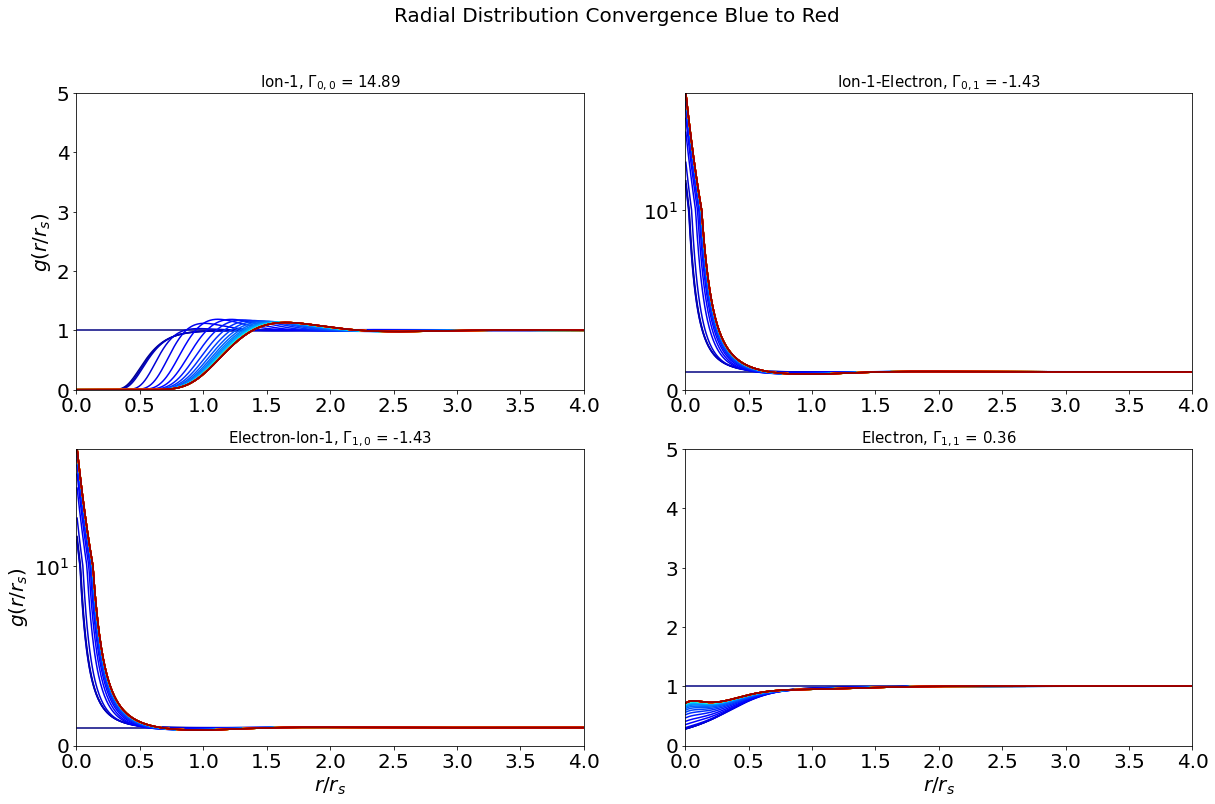

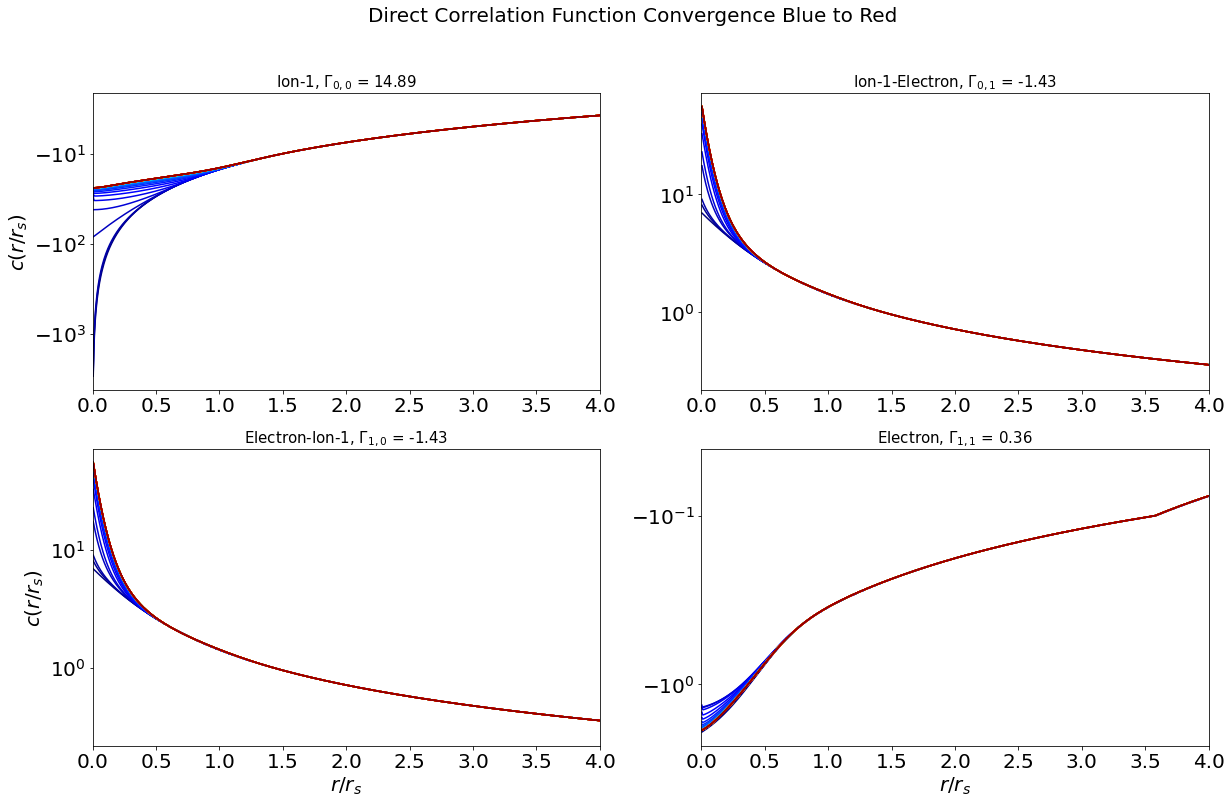

In [10]:
carbon.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/1)  )

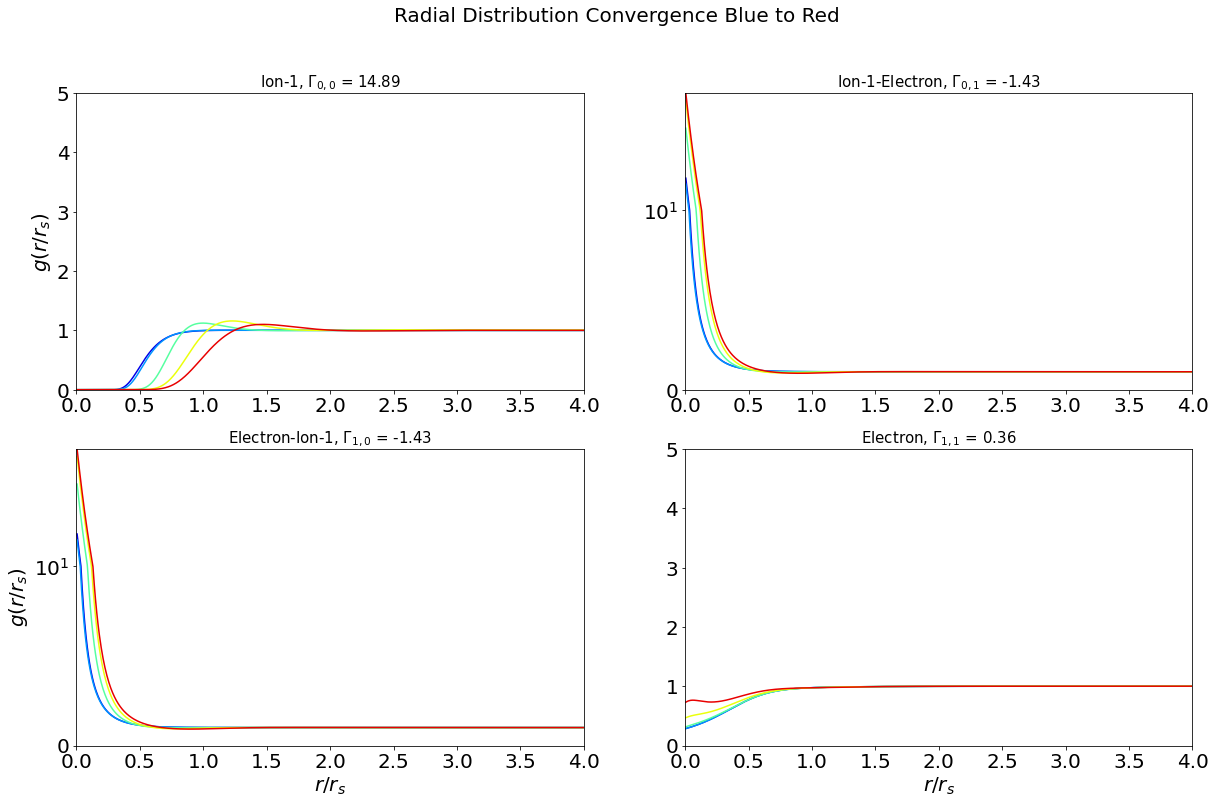

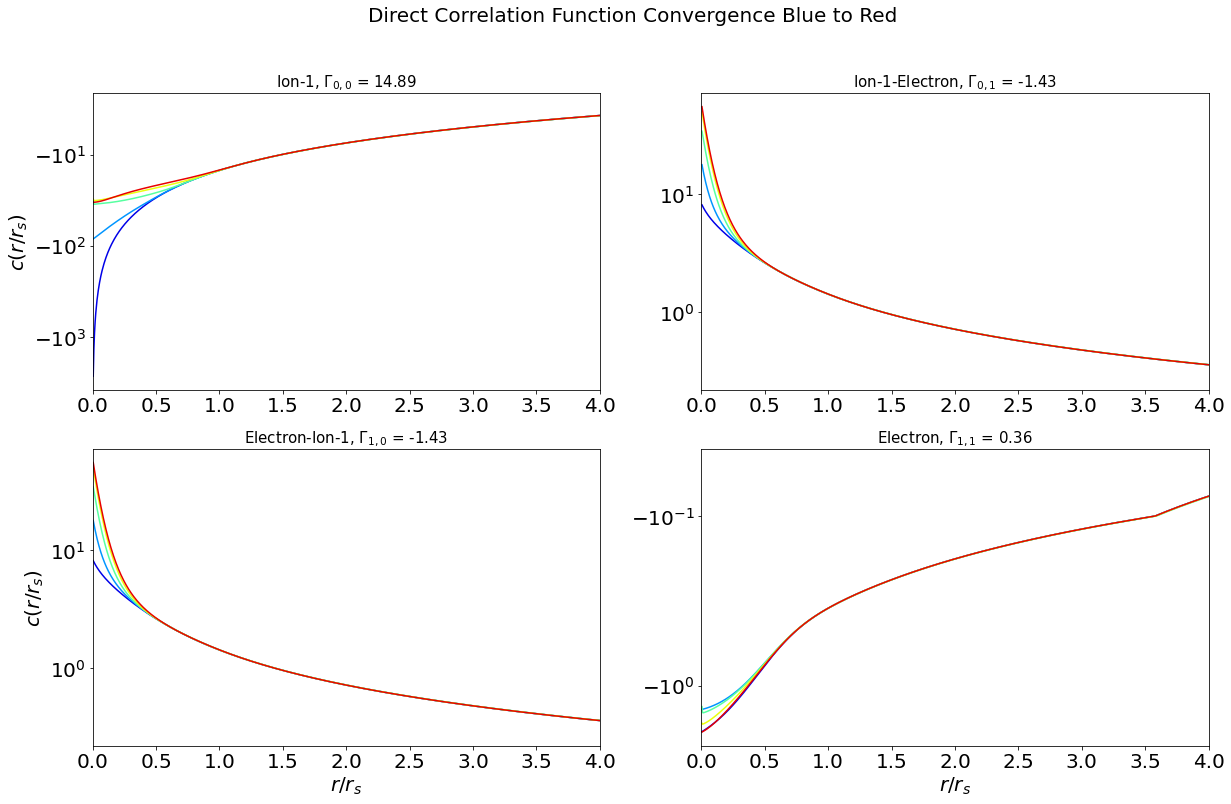

In [13]:
carbonSVT.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/10)  )
carbonSVT.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/10)  )

In [27]:
carbon_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, method='fixed', alpha=1 )

Λei = 0.205
Λee = 0.289
Λei = 0.205
Γii=14.889, Γie=-1.431, Γee=0.358 
r_i=1.360
r_e=0.857
θ  =3.15e-01
0: Err in c_r: 1.11e+02, OZ: 4.93e-16, HNC: 5.58e-16, tot: 4.45e-16, tot: 7.06e+00
1: Err in c_r: 7.00e+00, OZ: 1.63e-16, HNC: 5.98e-16, tot: 3.06e-16, tot: 2.52e+00
2: Err in c_r: 2.35e+00, OZ: 4.84e-16, HNC: 6.01e-16, tot: 2.54e-16, tot: 1.55e+00
3: Err in c_r: 1.26e+00, OZ: 1.02e-15, HNC: 5.66e-16, tot: 1.95e-16, tot: 1.21e+00
4: Err in c_r: 8.09e-01, OZ: 1.29e-15, HNC: 5.57e-16, tot: 1.94e-16, tot: 1.06e+00
5: Err in c_r: 5.64e-01, OZ: 4.66e-16, HNC: 5.12e-16, tot: 1.93e-16, tot: 9.82e-01
6: Err in c_r: 4.08e-01, OZ: 9.35e-16, HNC: 4.95e-16, tot: 2.17e-16, tot: 9.39e-01
7: Err in c_r: 3.03e-01, OZ: 9.00e-16, HNC: 5.07e-16, tot: 1.22e-16, tot: 9.15e-01
8: Err in c_r: 2.29e-01, OZ: 4.68e-16, HNC: 4.77e-16, tot: 1.22e-16, tot: 9.01e-01
9: Err in c_r: 1.75e-01, OZ: 2.60e-16, HNC: 4.72e-16, tot: 1.23e-16, tot: 8.92e-01
10: Err in c_r: 1.35e-01, OZ: 4.65e-16, HNC: 4.75e-16, tot: 1.21e-

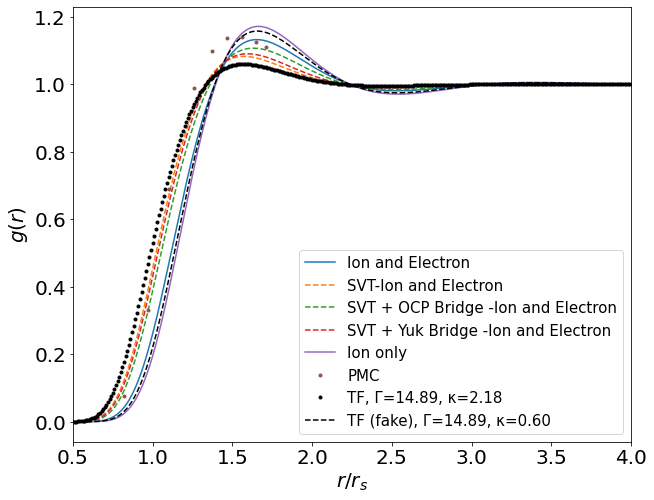

In [28]:
fig, ax = plt.subplots(figsize=(10,8))

# data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T8.62eV.txt",header=1, delim_whitespace=True)
# data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T430.9eV.txt",header=1, delim_whitespace=True)
data = read_csv("/home/zach/plasma/hnc/data/C_ri_1.36_T21.5eV.txt",header=1, delim_whitespace=True)
r_data, g_data = data['r/ri'], data['g_ii']

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='Ion and Electron')
ax.plot(carbon.r_array, carbonSVT.h_r_matrix[0,0]+1,'--', label='SVT-Ion and Electron')
ax.plot(carbon.r_array, carbonSVT_OCPBridge.h_r_matrix[0,0]+1,'--', label='SVT + OCP Bridge -Ion and Electron')
ax.plot(carbon.r_array, carbonSVT_YukBridge.h_r_matrix[0,0]+1,'--', label='SVT + Yuk Bridge -Ion and Electron')

ax.plot(carbon.r_array, carbon_one_species.h_r_matrix[0,0]+1, label="Ion only")


ax.plot(r_data, g_data, '.', label='PMC')
ax.plot(carbon_TF.r_array, carbon_TF.h_r_matrix[0,0]+1,'k.',label='TF, Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, κ))
ax.plot(carbon_TF_fake.r_array, carbon_TF_fake.h_r_matrix[0,0]+1,'k--',label='TF (fake), Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, fake_κ))


ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


## Hydrogen

In [82]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, hydrogenqsp = run_hnc(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
73.2504115213469
HNC α: 1.0e-02, c_err: 7.3e+01 
73.23916312844997
HNC α: 1.1e-02, c_err: 7.3e+01 
73.22792075574746
HNC α: 1.1e-02, c_err: 7.3e+01 
73.21668439683768
HNC α: 1.1e-02, c_err: 7.3e+01 
73.1942296948514
HNC α: 1.2e-02, c_err: 7.3e+01 
73.17179897152036
HNC α: 1.4e-02, c_err: 7.3e+01 
73.12700925790271
HNC α: 1.6e-02, c_err: 7.3e+01 
73.08231485205037
HNC α: 1.8e-02, c_err: 7.3e+01 
72.99321036306095
HNC α: 2.2e-02, c_err: 7.3e+01 
72.90448233332798
HNC α: 2.6e-02, c_err: 7.3e+01 
72.72814320248403
HNC α: 3.4e-02, c_err: 7.3e+01 
72.55327302129434
HNC α: 4.2e-02, c_err: 7.3e+01 
72.20784532253708
HNC α: 5.8e-02, c_err: 7.2e+01 
71.868017665465
HNC α: 7.4e-02, c_err: 7.2e+01 
71.20448737937815
HNC α: 1.1e-01, c_err: 7.1e+01 
70.56142522205496
HNC α: 1.4e-01, c_err: 7.1e+01 
69.33234243761463
HNC α: 2.0e-01, c_err: 6.9e+01 
68.17315971597127
HNC α: 2.7e-01, c_err: 6.8e+01 
66.0413086807

In [84]:
κ = get_κ(Zstar, ri, Ti, hydrogenqsp.E_F)


print("κ= ", κ)
hydrogen_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='geometric', method='fixed',
                            alpha=1e0, num_iterations=1e3)

κ=  1.8589205598017642
Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.946, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.49e+01, OZ: 1.38e-16, HNC: 4.58e-17, tot: 0.19
1: Err in c_r: 2.60e+00, OZ: 9.84e-17, HNC: 4.20e-17, tot: 0.21
2: Err in c_r: 7.41e-01, OZ: 1.10e-16, HNC: 3.76e-17, tot: 0.24
3: Err in c_r: 3.34e-01, OZ: 7.76e-17, HNC: 3.23e-17, tot: 0.26
4: Err in c_r: 1.77e-01, OZ: 7.06e-17, HNC: 3.23e-17, tot: 0.28
5: Err in c_r: 9.95e-02, OZ: 8.16e-17, HNC: 3.39e-17, tot: 0.30
6: Err in c_r: 5.73e-02, OZ: 3.65e-17, HNC: 2.88e-17, tot: 0.31
7: Err in c_r: 3.34e-02, OZ: 7.45e-17, HNC: 2.46e-17, tot: 0.32
8: Err in c_r: 1.96e-02, OZ: 6.30e-17, HNC: 2.93e-17, tot: 0.33
9: Err in c_r: 1.16e-02, OZ: 7.13e-17, HNC: 2.77e-17, tot: 0.33
10: Err in c_r: 6.87e-03, OZ: 7.91e-17, HNC: 2.64e-17, tot: 0.33
11: Err in c_r: 4.07e-03, OZ: 4.72e-17, HNC: 3.06e-17, tot: 0.33
12: Err in c_r: 2.42e-03, OZ: 6.71e-17, HNC: 2.35e-17, tot: 0.33
13: Err in c_r: 1.44e-03, OZ: 5.34e-17, HNC: 2.26e-

In [85]:
fake_κ=0.6
hydrogen_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='geometric', 
                               method='fixed', alpha=1e0, num_iterations=1e3)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.946, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.51e+01, OZ: 3.03e-16, HNC: 1.43e-16, tot: 0.19
1: Err in c_r: 2.79e+00, OZ: 6.73e-16, HNC: 1.30e-16, tot: 0.22
2: Err in c_r: 8.98e-01, OZ: 2.23e-16, HNC: 1.17e-16, tot: 0.24
3: Err in c_r: 4.59e-01, OZ: 4.44e-16, HNC: 1.11e-16, tot: 0.27
4: Err in c_r: 2.79e-01, OZ: 3.54e-16, HNC: 1.01e-16, tot: 0.29
5: Err in c_r: 1.81e-01, OZ: 2.74e-16, HNC: 9.50e-17, tot: 0.31
6: Err in c_r: 1.22e-01, OZ: 2.95e-16, HNC: 9.44e-17, tot: 0.33
7: Err in c_r: 8.38e-02, OZ: 1.24e-16, HNC: 8.32e-17, tot: 0.35
8: Err in c_r: 5.83e-02, OZ: 1.36e-16, HNC: 7.84e-17, tot: 0.36
9: Err in c_r: 4.10e-02, OZ: 1.84e-16, HNC: 9.02e-17, tot: 0.36
10: Err in c_r: 2.90e-02, OZ: 2.00e-16, HNC: 8.93e-17, tot: 0.37
11: Err in c_r: 2.05e-02, OZ: 4.15e-16, HNC: 8.00e-17, tot: 0.38
12: Err in c_r: 1.46e-02, OZ: 3.45e-16, HNC: 8.62e-17, tot: 0.38
13: Err in c_r: 1.04e-02, OZ: 1.97e-16, HNC: 7.35e-17, tot: 0.38
14: Err i

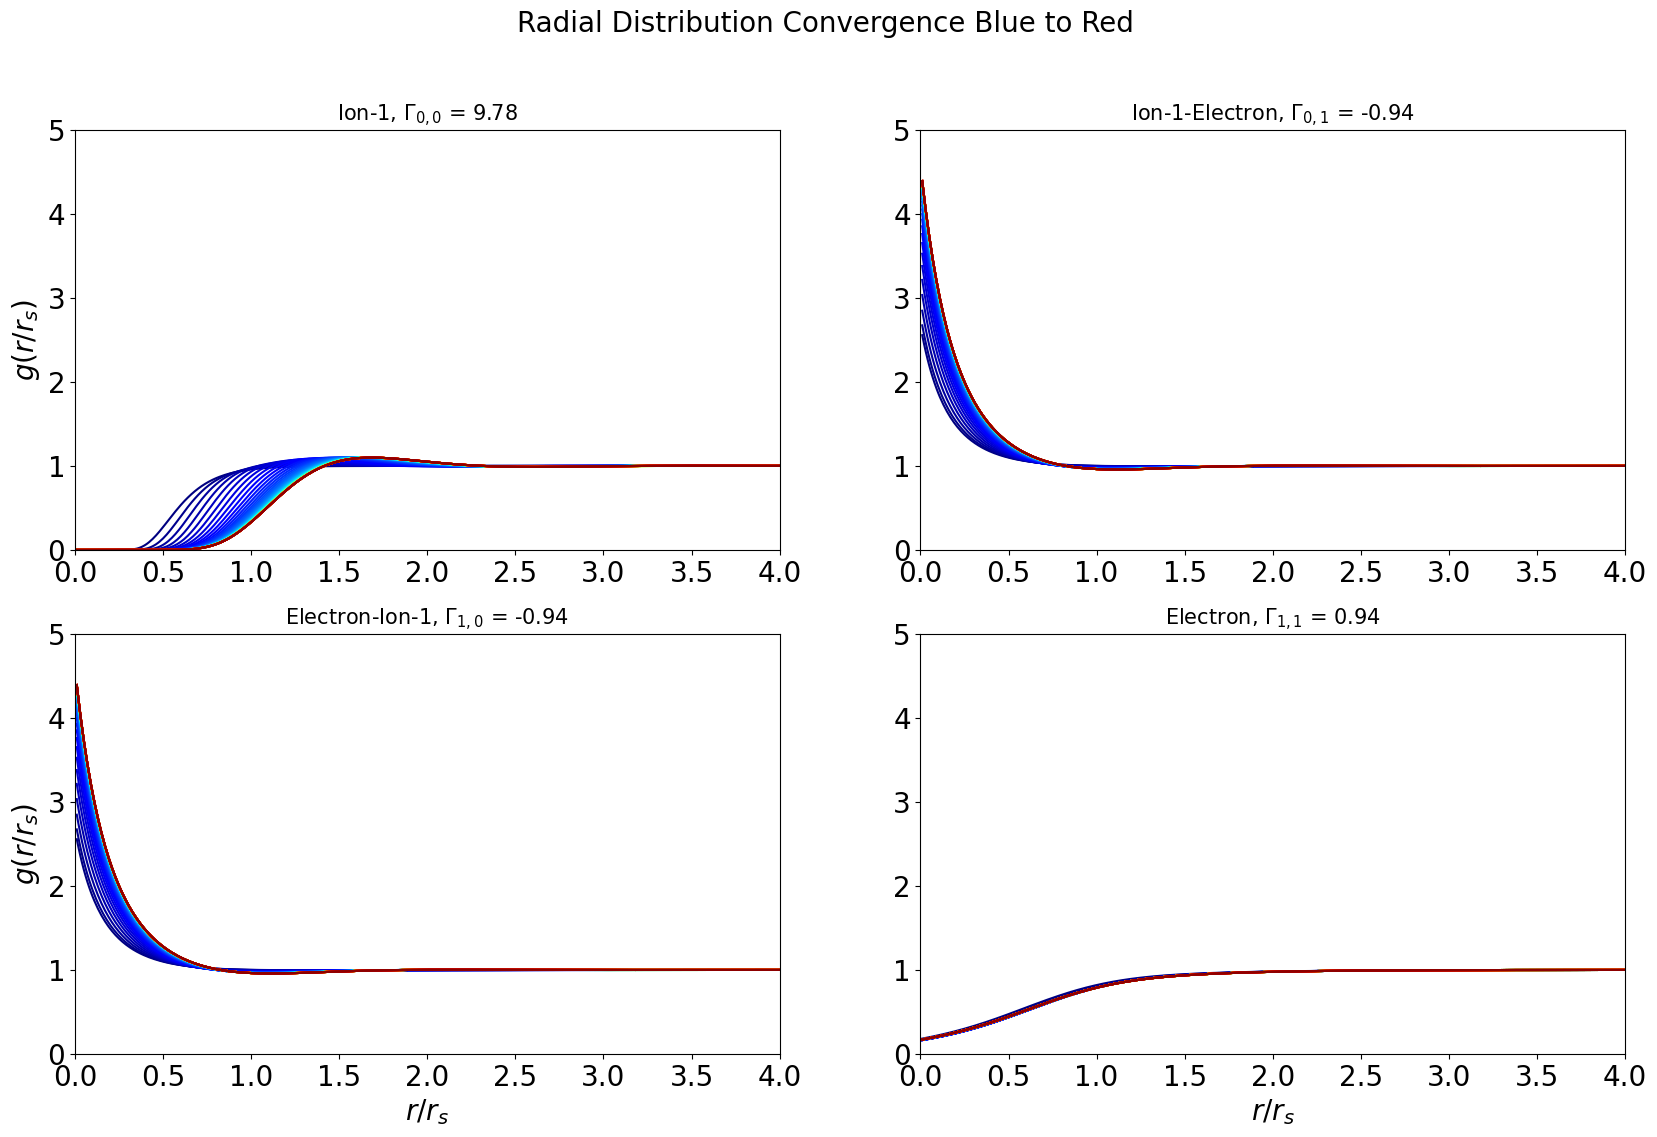

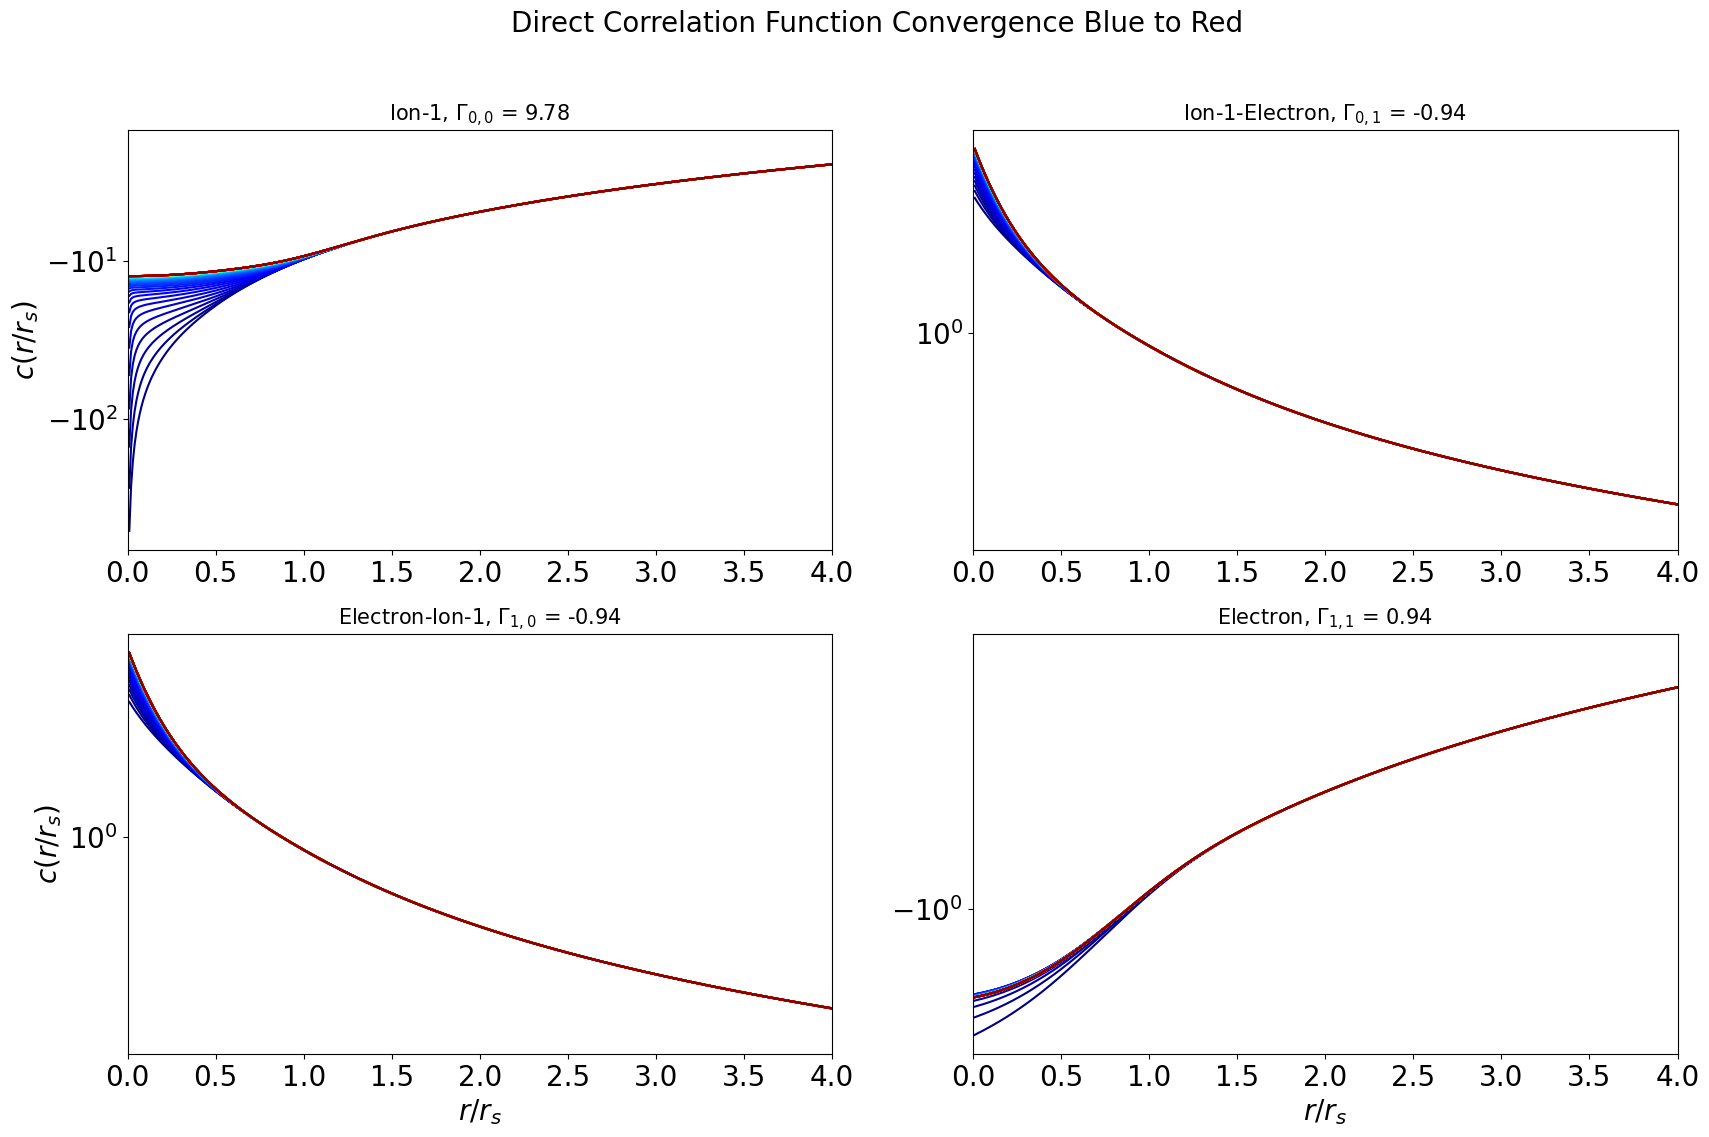

In [13]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

In [14]:
hydrogen_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00622755] True Optimization terminated successfully.
0: Err in c_r: 2.50e+01, OZ: 1.76e-01, HNC: 1.69e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00150468] True Optimization terminated successfully.
1: Err in c_r: 1.32e+01, OZ: 1.61e-01, HNC: 1.22e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 7.04e+00, OZ: 1.49e-01, HNC: 1.04e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00211778] True Optimization terminated successfully.
3: Err in c_r: 3.81e+00, OZ: 1.28e-01, HNC: 9.42e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00179076] True Optimization terminated successfully.
4: Err in c_r: 2.09e+00, OZ: 1.14e-01, HNC: 9.05e-03
 HNC min: [0.5] True Optimi

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 2.30e-04, OZ: 1.44e-04, HNC: 1.37e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.99e-04, OZ: 1.24e-04, HNC: 1.18e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.72e-04, OZ: 1.08e-04, HNC: 1.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.49e-04, OZ: 9.33e-05, HNC: 8.87e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.29e-04, OZ: 8.08e-05, HNC: 7.68e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
58: Err in c_r: 1.12e-04, OZ

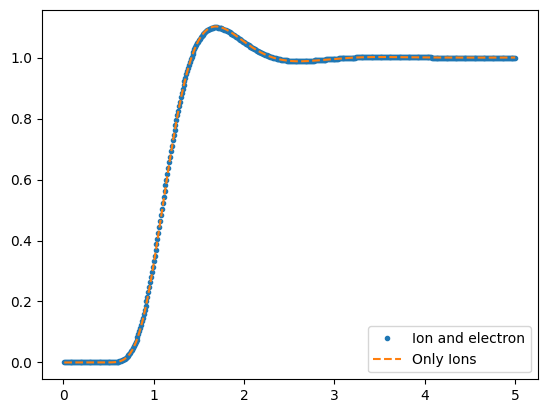

In [15]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1,'.', label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, '--',label="Only Ions")
ax.legend()

## Aluminum

In [48]:
ni = 6.03e22 # per cc
Te = 30*eV 
Ti   = 30*eV 
Z, A = 13,27
Zstar= 3
# aluminum_i_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3 )
# aluminum_e_one_species, _ = run_hnc_one_electron(ni, Te, 1, 1, Zstar, num_iterations=1e3 )


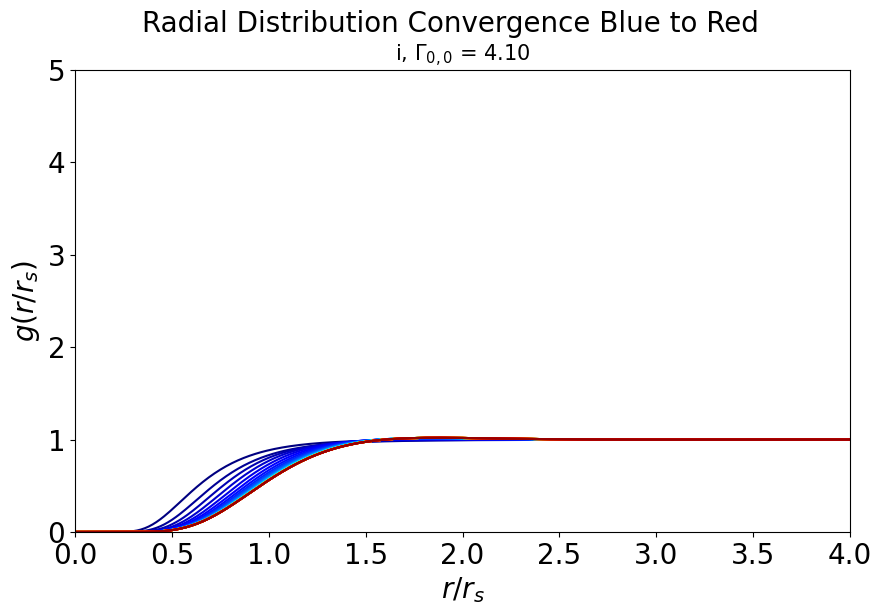

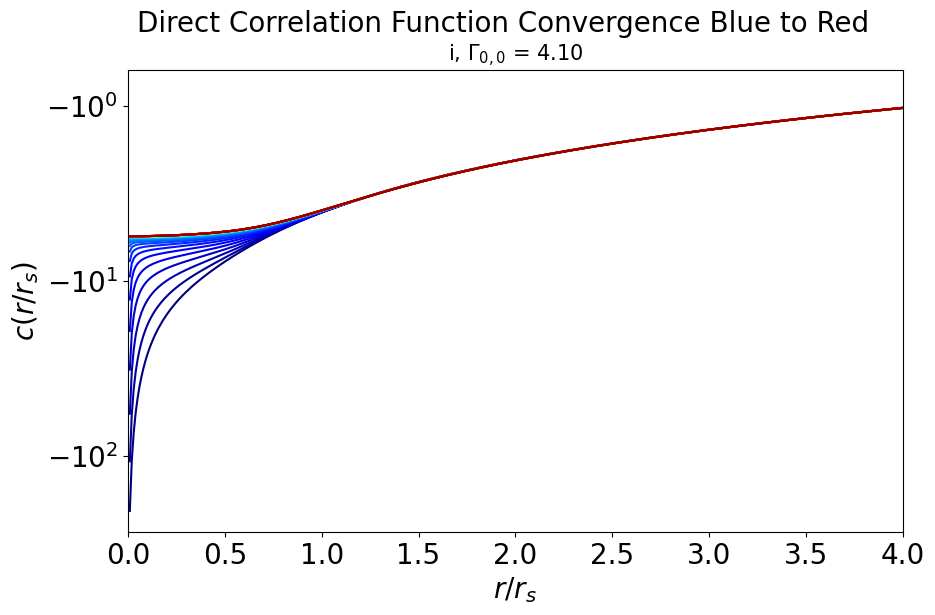

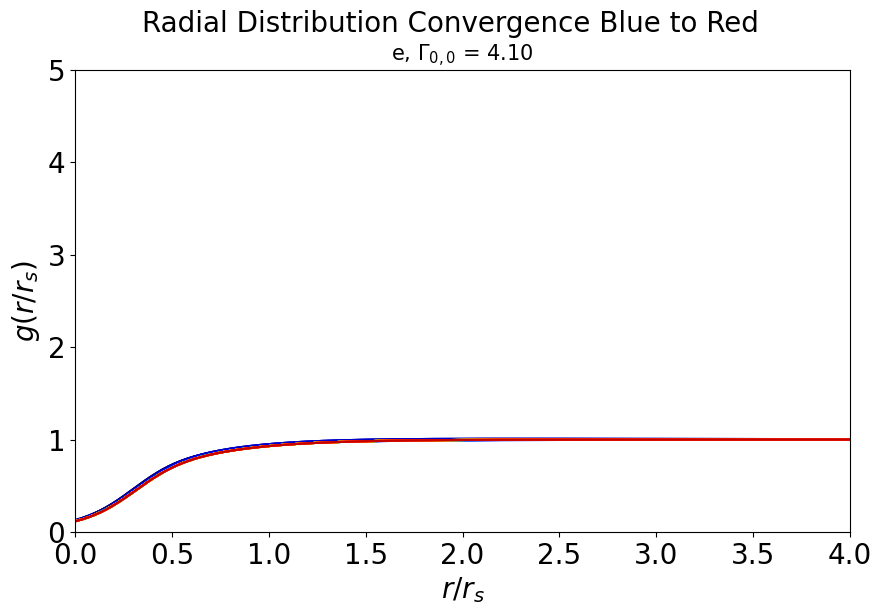

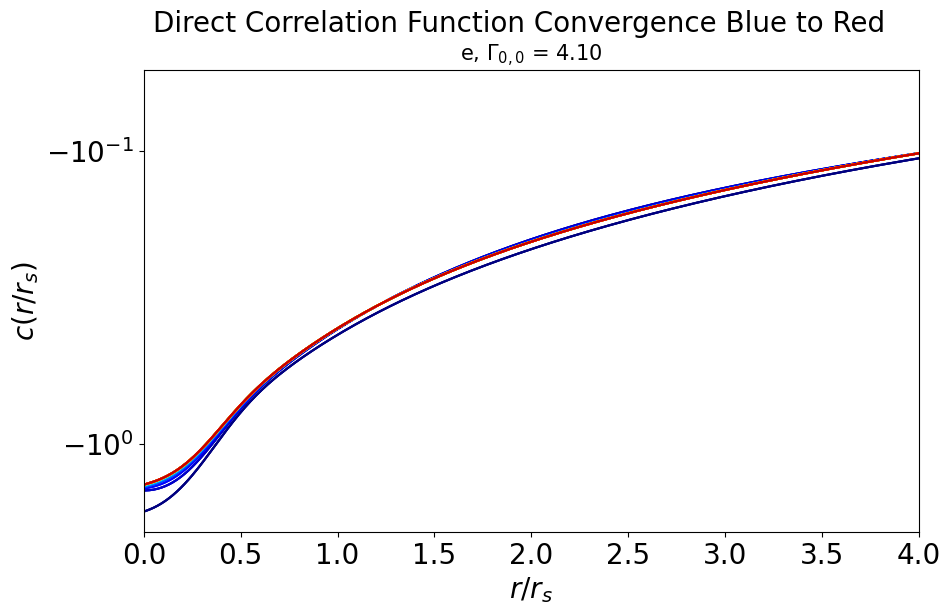

In [19]:
aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )

In [20]:
c_s_r_guess = np.zeros((2,2,N_bins))
c_s_r_guess[0,0] = aluminum_i_one_species.c_s_r_matrix
c_s_r_guess[1,1] = aluminum_e_one_species.c_s_r_matrix

In [21]:
# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[:,:] = aluminum.c_s_r_matrix[:,:]

In [51]:
aluminum, _ = run_hnc(ni, Te, Z, A, Zstar, method='fixed', num_iterations=1e4, alpha=1e-1, c_s_r_guess=c_s_r_guess )

Λee = 0.175
Λei = 0.124
Γii=2.731, Γie=-0.865, Γee=0.288 
r_i=2.989
r_e=2.073
θ  =2.57e+00
0: Err in c_r: 8.14e-01, OZ: 2.62e-01, HNC: 7.24e+79
1: Err in c_r: 9.21e-01, OZ: 2.44e-01, HNC: 5.19e+74
2: Err in c_r: 8.07e-01, OZ: 2.17e-01, HNC: 2.94e+65
3: Err in c_r: 7.14e-01, OZ: 1.92e-01, HNC: 7.32e+57
4: Err in c_r: 6.35e-01, OZ: 1.71e-01, HNC: 2.83e+51
5: Err in c_r: 5.66e-01, OZ: 1.52e-01, HNC: 7.62e+45
6: Err in c_r: 5.05e-01, OZ: 1.35e-01, HNC: 7.92e+40
7: Err in c_r: 4.48e-01, OZ: 1.20e-01, HNC: 2.12e+36
8: Err in c_r: 3.94e-01, OZ: 1.07e-01, HNC: 1.12e+32
9: Err in c_r: 3.44e-01, OZ: 9.54e-02, HNC: 9.94e+27
10: Err in c_r: 2.96e-01, OZ: 8.49e-02, HNC: 1.40e+24
11: Err in c_r: 2.50e-01, OZ: 7.56e-02, HNC: 3.05e+20
12: Err in c_r: 2.07e-01, OZ: 6.72e-02, HNC: 1.06e+17
13: Err in c_r: 1.66e-01, OZ: 5.98e-02, HNC: 6.06e+13
14: Err in c_r: 1.29e-01, OZ: 5.33e-02, HNC: 5.99e+10
15: Err in c_r: 9.47e-02, OZ: 4.75e-02, HNC: 1.05e+08
16: Err in c_r: 6.46e-02, OZ: 4.25e-02, HNC: 3.38e+05
1

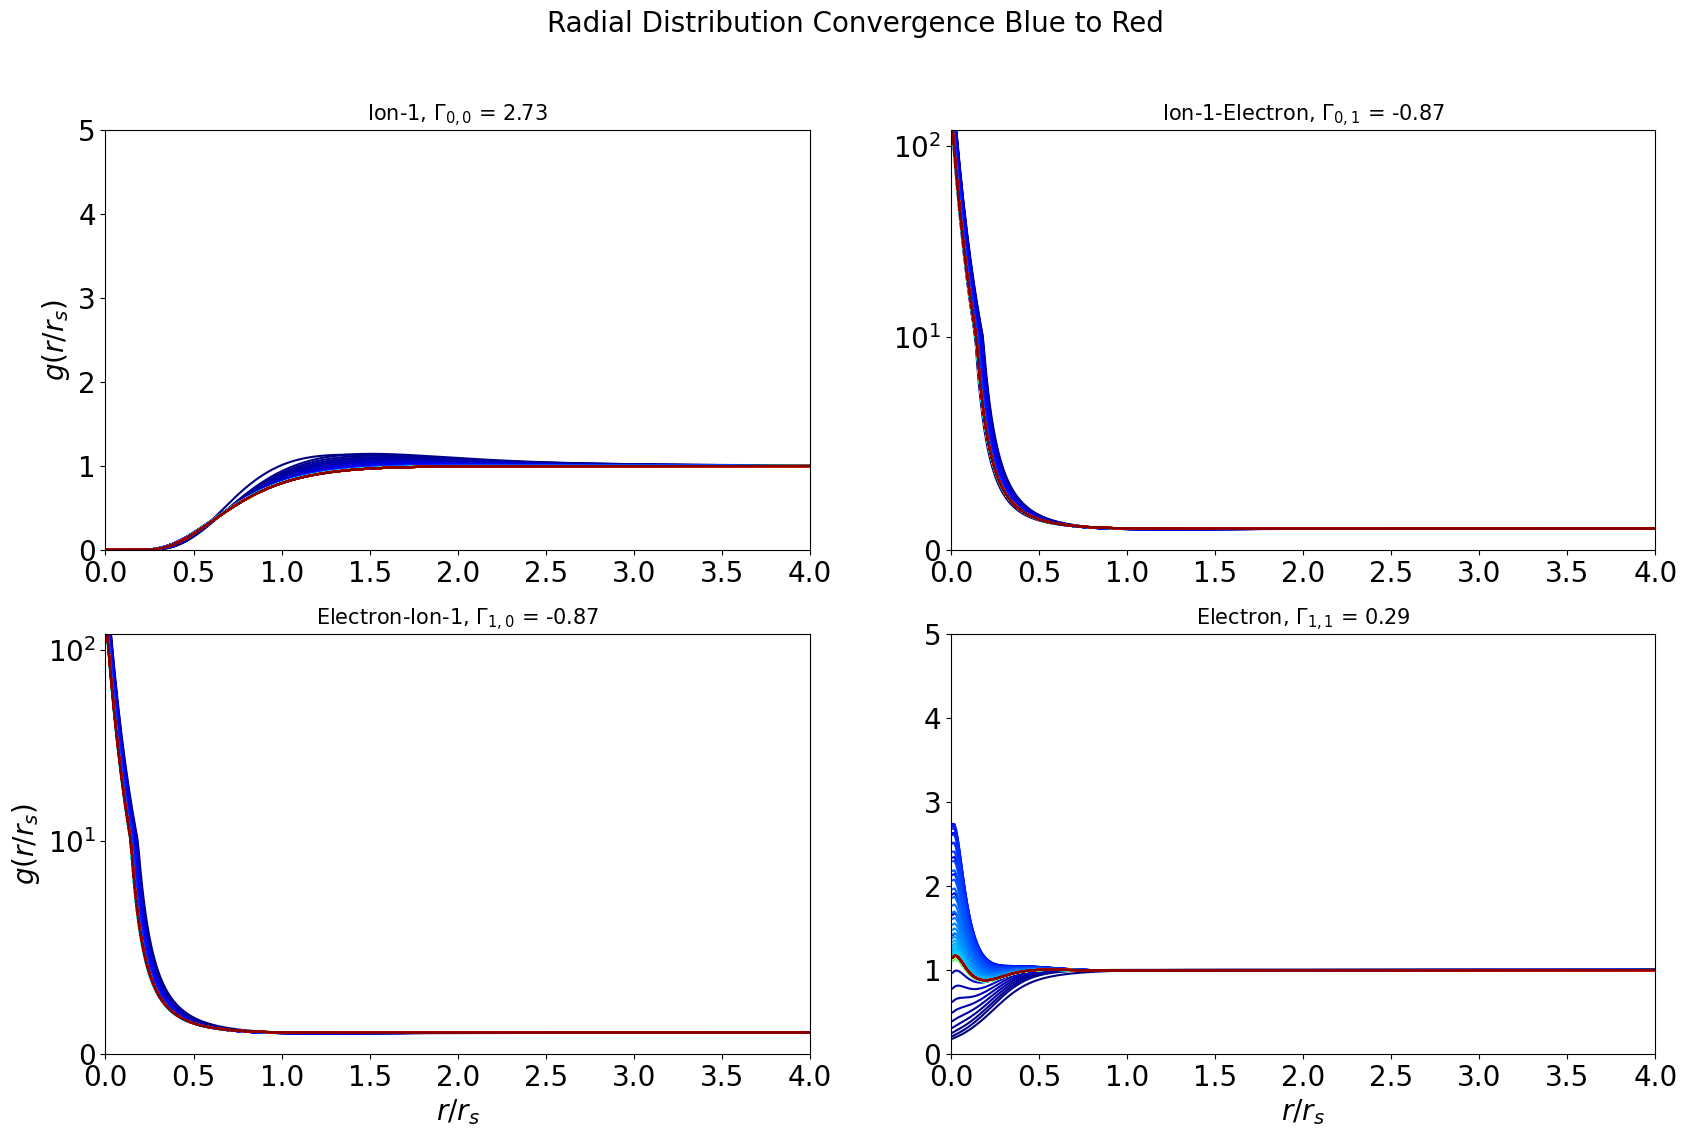

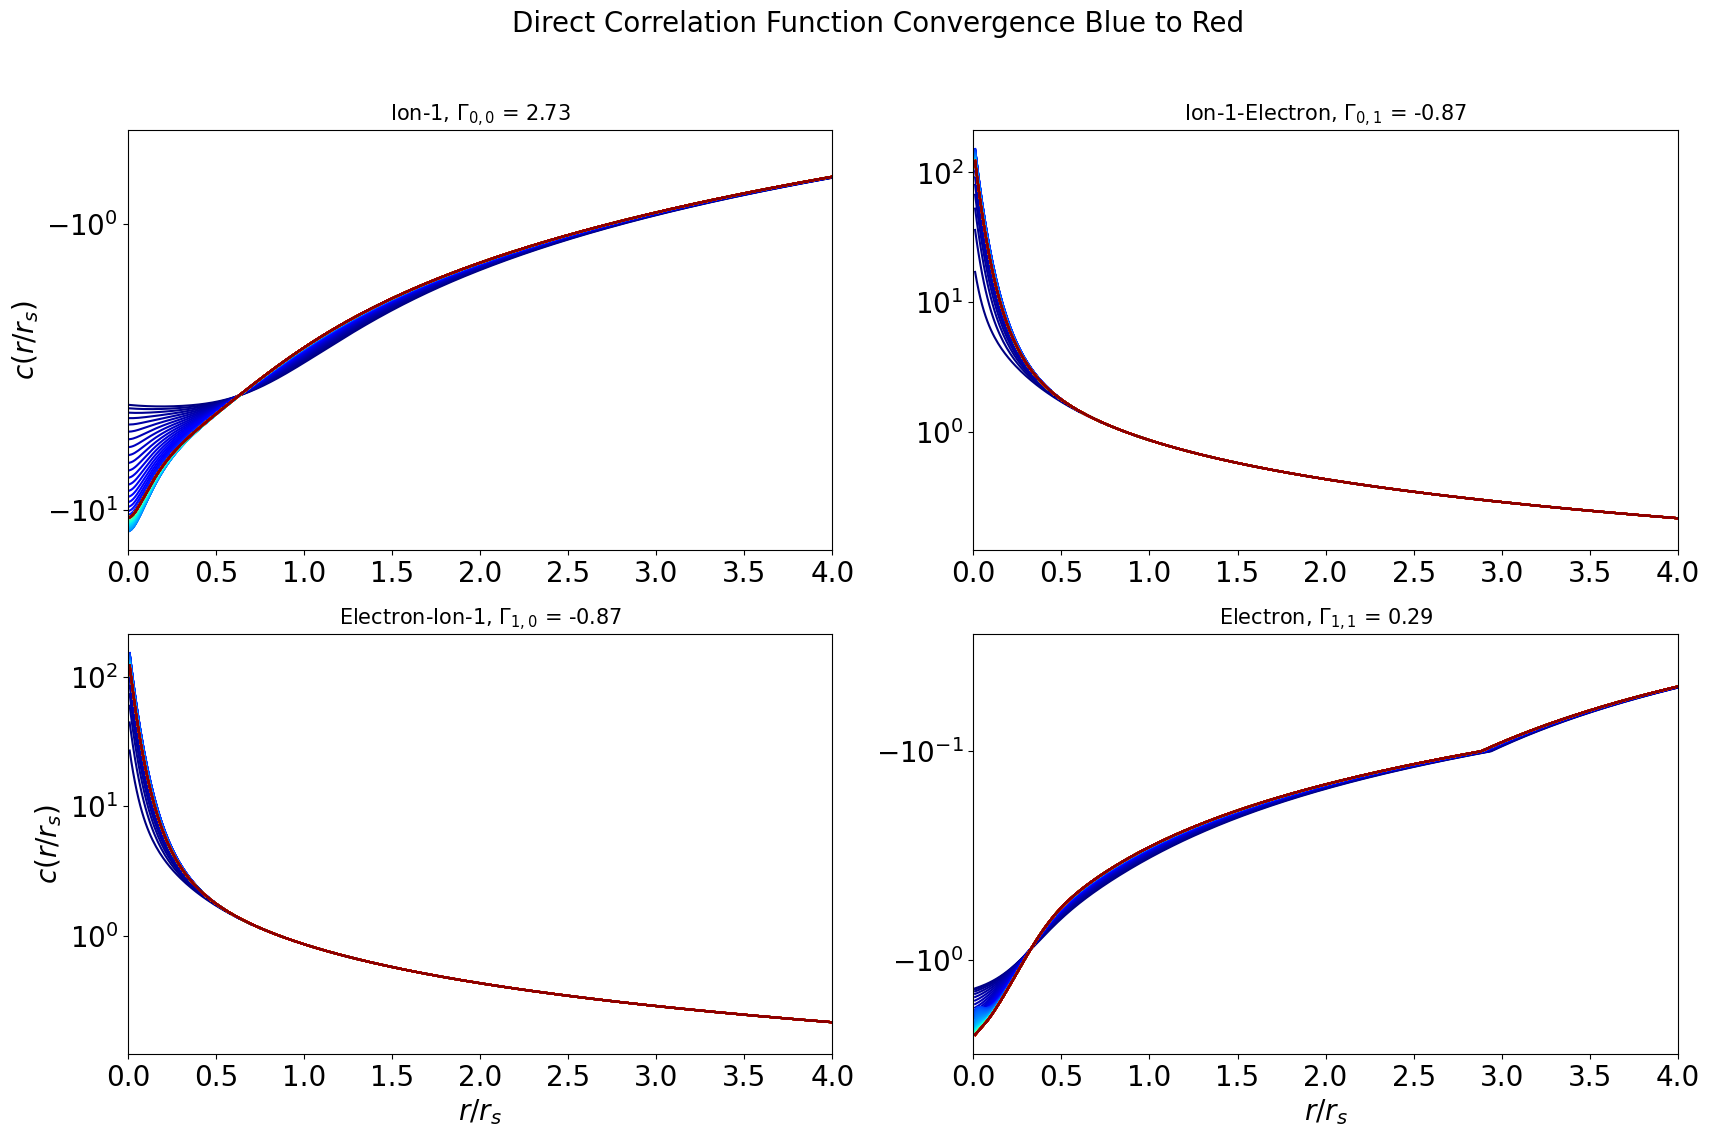

In [52]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

## Copper

In [29]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206
# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix

copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed',alpha=1e-1)

Λei = 0.295
Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 5.54e+00, OZ: 1.49e-01, HNC: 5.17e+00, tot: 4.99e+01, tot: 5.02e+01
1: Err in c_r: 5.02e+00, OZ: 1.46e-01, HNC: 3.59e+00, tot: 4.51e+01, tot: 4.54e+01
2: Err in c_r: 4.54e+00, OZ: 1.43e-01, HNC: 2.69e+00, tot: 4.09e+01, tot: 4.11e+01
3: Err in c_r: 4.11e+00, OZ: 1.40e-01, HNC: 2.14e+00, tot: 3.70e+01, tot: 3.72e+01
4: Err in c_r: 3.72e+00, OZ: 1.38e-01, HNC: 1.78e+00, tot: 3.35e+01, tot: 3.37e+01
5: Err in c_r: 3.37e+00, OZ: 1.35e-01, HNC: 1.55e+00, tot: 3.03e+01, tot: 3.05e+01
6: Err in c_r: 3.05e+00, OZ: 1.33e-01, HNC: 1.39e+00, tot: 2.74e+01, tot: 2.76e+01
7: Err in c_r: 2.76e+00, OZ: 1.30e-01, HNC: 1.28e+00, tot: 2.48e+01, tot: 2.50e+01
8: Err in c_r: 2.50e+00, OZ: 1.28e-01, HNC: 1.20e+00, tot: 2.25e+01, tot: 2.26e+01
9: Err in c_r: 2.26e+00, OZ: 1.26e-01, HNC: 1.16e+00, tot: 2.03e+01, tot: 2.05e+01
10: Err in c_r: 2.05e+00, OZ: 1.24e-01, HNC: 1.13e+00, tot: 1.84e+

104: Err in c_r: 8.06e-03, OZ: 2.43e-02, HNC: 6.16e-01, tot: 7.25e-02, tot: 1.34e+00
105: Err in c_r: 7.85e-03, OZ: 2.38e-02, HNC: 5.99e-01, tot: 7.07e-02, tot: 1.34e+00
106: Err in c_r: 7.65e-03, OZ: 2.33e-02, HNC: 5.82e-01, tot: 6.89e-02, tot: 1.34e+00
107: Err in c_r: 7.46e-03, OZ: 2.28e-02, HNC: 5.66e-01, tot: 6.71e-02, tot: 1.34e+00
108: Err in c_r: 7.27e-03, OZ: 2.24e-02, HNC: 5.50e-01, tot: 6.54e-02, tot: 1.34e+00
109: Err in c_r: 7.09e-03, OZ: 2.19e-02, HNC: 5.35e-01, tot: 6.38e-02, tot: 1.34e+00
110: Err in c_r: 6.91e-03, OZ: 2.15e-02, HNC: 5.20e-01, tot: 6.22e-02, tot: 1.34e+00
111: Err in c_r: 6.74e-03, OZ: 2.10e-02, HNC: 5.06e-01, tot: 6.07e-02, tot: 1.34e+00
112: Err in c_r: 6.57e-03, OZ: 2.06e-02, HNC: 4.92e-01, tot: 5.92e-02, tot: 1.34e+00
113: Err in c_r: 6.41e-03, OZ: 2.02e-02, HNC: 4.79e-01, tot: 5.77e-02, tot: 1.34e+00
114: Err in c_r: 6.25e-03, OZ: 1.98e-02, HNC: 4.66e-01, tot: 5.63e-02, tot: 1.34e+00
115: Err in c_r: 6.10e-03, OZ: 1.94e-02, HNC: 4.53e-01, tot: 5.49

208: Err in c_r: 7.02e-04, OZ: 2.60e-03, HNC: 4.76e-02, tot: 6.32e-03, tot: 1.37e+00
209: Err in c_r: 6.87e-04, OZ: 2.54e-03, HNC: 4.66e-02, tot: 6.18e-03, tot: 1.37e+00
210: Err in c_r: 6.71e-04, OZ: 2.49e-03, HNC: 4.55e-02, tot: 6.04e-03, tot: 1.37e+00
211: Err in c_r: 6.56e-04, OZ: 2.43e-03, HNC: 4.45e-02, tot: 5.91e-03, tot: 1.37e+00
212: Err in c_r: 6.42e-04, OZ: 2.38e-03, HNC: 4.35e-02, tot: 5.78e-03, tot: 1.37e+00
213: Err in c_r: 6.28e-04, OZ: 2.33e-03, HNC: 4.25e-02, tot: 5.65e-03, tot: 1.37e+00
214: Err in c_r: 6.14e-04, OZ: 2.28e-03, HNC: 4.16e-02, tot: 5.52e-03, tot: 1.37e+00
215: Err in c_r: 6.00e-04, OZ: 2.23e-03, HNC: 4.06e-02, tot: 5.40e-03, tot: 1.37e+00
216: Err in c_r: 5.87e-04, OZ: 2.18e-03, HNC: 3.97e-02, tot: 5.28e-03, tot: 1.37e+00
217: Err in c_r: 5.74e-04, OZ: 2.13e-03, HNC: 3.88e-02, tot: 5.16e-03, tot: 1.37e+00
218: Err in c_r: 5.61e-04, OZ: 2.09e-03, HNC: 3.80e-02, tot: 5.05e-03, tot: 1.37e+00
219: Err in c_r: 5.49e-04, OZ: 2.04e-03, HNC: 3.71e-02, tot: 4.94

311: Err in c_r: 7.07e-05, OZ: 2.67e-04, HNC: 4.74e-03, tot: 6.36e-04, tot: 1.38e+00
312: Err in c_r: 6.91e-05, OZ: 2.61e-04, HNC: 4.64e-03, tot: 6.22e-04, tot: 1.38e+00
313: Err in c_r: 6.76e-05, OZ: 2.55e-04, HNC: 4.54e-03, tot: 6.08e-04, tot: 1.38e+00
314: Err in c_r: 6.61e-05, OZ: 2.50e-04, HNC: 4.44e-03, tot: 5.95e-04, tot: 1.38e+00
315: Err in c_r: 6.47e-05, OZ: 2.44e-04, HNC: 4.34e-03, tot: 5.82e-04, tot: 1.38e+00
316: Err in c_r: 6.33e-05, OZ: 2.39e-04, HNC: 4.24e-03, tot: 5.69e-04, tot: 1.38e+00
317: Err in c_r: 6.19e-05, OZ: 2.33e-04, HNC: 4.15e-03, tot: 5.57e-04, tot: 1.38e+00
318: Err in c_r: 6.05e-05, OZ: 2.28e-04, HNC: 4.06e-03, tot: 5.45e-04, tot: 1.38e+00
319: Err in c_r: 5.92e-05, OZ: 2.23e-04, HNC: 3.97e-03, tot: 5.33e-04, tot: 1.38e+00
320: Err in c_r: 5.79e-05, OZ: 2.18e-04, HNC: 3.88e-03, tot: 5.21e-04, tot: 1.38e+00
321: Err in c_r: 5.66e-05, OZ: 2.14e-04, HNC: 3.80e-03, tot: 5.09e-04, tot: 1.38e+00
322: Err in c_r: 5.54e-05, OZ: 2.09e-04, HNC: 3.71e-03, tot: 4.98

414: Err in c_r: 7.19e-06, OZ: 2.72e-05, HNC: 4.82e-04, tot: 6.47e-05, tot: 1.38e+00
415: Err in c_r: 7.04e-06, OZ: 2.66e-05, HNC: 4.71e-04, tot: 6.33e-05, tot: 1.38e+00
416: Err in c_r: 6.88e-06, OZ: 2.60e-05, HNC: 4.61e-04, tot: 6.19e-05, tot: 1.38e+00
417: Err in c_r: 6.73e-06, OZ: 2.54e-05, HNC: 4.51e-04, tot: 6.06e-05, tot: 1.38e+00
418: Err in c_r: 6.58e-06, OZ: 2.49e-05, HNC: 4.41e-04, tot: 5.92e-05, tot: 1.38e+00
419: Err in c_r: 6.44e-06, OZ: 2.43e-05, HNC: 4.31e-04, tot: 5.79e-05, tot: 1.38e+00
420: Err in c_r: 6.30e-06, OZ: 2.38e-05, HNC: 4.22e-04, tot: 5.67e-05, tot: 1.38e+00
421: Err in c_r: 6.16e-06, OZ: 2.33e-05, HNC: 4.13e-04, tot: 5.54e-05, tot: 1.38e+00
422: Err in c_r: 6.02e-06, OZ: 2.28e-05, HNC: 4.04e-04, tot: 5.42e-05, tot: 1.38e+00
423: Err in c_r: 5.89e-06, OZ: 2.23e-05, HNC: 3.95e-04, tot: 5.30e-05, tot: 1.38e+00
424: Err in c_r: 5.76e-06, OZ: 2.18e-05, HNC: 3.86e-04, tot: 5.19e-05, tot: 1.38e+00
425: Err in c_r: 5.64e-06, OZ: 2.13e-05, HNC: 3.78e-04, tot: 5.07

512: Err in c_r: 8.19e-07, OZ: 3.10e-06, HNC: 5.49e-05, tot: 7.37e-06, tot: 1.38e+00
513: Err in c_r: 8.01e-07, OZ: 3.03e-06, HNC: 5.37e-05, tot: 7.21e-06, tot: 1.38e+00
514: Err in c_r: 7.83e-07, OZ: 2.96e-06, HNC: 5.25e-05, tot: 7.05e-06, tot: 1.38e+00
515: Err in c_r: 7.66e-07, OZ: 2.90e-06, HNC: 5.13e-05, tot: 6.90e-06, tot: 1.38e+00
516: Err in c_r: 7.49e-07, OZ: 2.83e-06, HNC: 5.02e-05, tot: 6.74e-06, tot: 1.38e+00
517: Err in c_r: 7.33e-07, OZ: 2.77e-06, HNC: 4.91e-05, tot: 6.60e-06, tot: 1.38e+00
518: Err in c_r: 7.17e-07, OZ: 2.71e-06, HNC: 4.80e-05, tot: 6.45e-06, tot: 1.38e+00
519: Err in c_r: 7.01e-07, OZ: 2.65e-06, HNC: 4.70e-05, tot: 6.31e-06, tot: 1.38e+00
520: Err in c_r: 6.86e-07, OZ: 2.59e-06, HNC: 4.60e-05, tot: 6.17e-06, tot: 1.38e+00
521: Err in c_r: 6.71e-07, OZ: 2.54e-06, HNC: 4.49e-05, tot: 6.04e-06, tot: 1.38e+00
522: Err in c_r: 6.56e-07, OZ: 2.48e-06, HNC: 4.40e-05, tot: 5.90e-06, tot: 1.38e+00
523: Err in c_r: 6.42e-07, OZ: 2.43e-06, HNC: 4.30e-05, tot: 5.77

614: Err in c_r: 8.53e-08, OZ: 3.23e-07, HNC: 5.72e-06, tot: 7.68e-07, tot: 1.38e+00
615: Err in c_r: 8.34e-08, OZ: 3.16e-07, HNC: 5.59e-06, tot: 7.51e-07, tot: 1.38e+00
616: Err in c_r: 8.16e-08, OZ: 3.09e-07, HNC: 5.47e-06, tot: 7.34e-07, tot: 1.38e+00
617: Err in c_r: 7.98e-08, OZ: 3.02e-07, HNC: 5.35e-06, tot: 7.18e-07, tot: 1.38e+00
618: Err in c_r: 7.81e-08, OZ: 2.95e-07, HNC: 5.23e-06, tot: 7.03e-07, tot: 1.38e+00
619: Err in c_r: 7.64e-08, OZ: 2.89e-07, HNC: 5.12e-06, tot: 6.87e-07, tot: 1.38e+00
620: Err in c_r: 7.47e-08, OZ: 2.82e-07, HNC: 5.00e-06, tot: 6.72e-07, tot: 1.38e+00
621: Err in c_r: 7.30e-08, OZ: 2.76e-07, HNC: 4.89e-06, tot: 6.57e-07, tot: 1.38e+00
622: Err in c_r: 7.14e-08, OZ: 2.70e-07, HNC: 4.79e-06, tot: 6.43e-07, tot: 1.38e+00
623: Err in c_r: 6.99e-08, OZ: 2.64e-07, HNC: 4.68e-06, tot: 6.29e-07, tot: 1.38e+00
624: Err in c_r: 6.83e-08, OZ: 2.58e-07, HNC: 4.58e-06, tot: 6.15e-07, tot: 1.38e+00
625: Err in c_r: 6.68e-08, OZ: 2.53e-07, HNC: 4.48e-06, tot: 6.02

In [30]:
copperSVT,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed',alpha=1e-1, oz_type='svt')

Λei = 0.295
Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 5.54e+00, OZ: 1.47e-01, HNC: 6.65e+00, tot: 4.99e+01, tot: 5.02e+01
1: Err in c_r: 5.02e+00, OZ: 1.44e-01, HNC: 4.46e+00, tot: 4.51e+01, tot: 4.54e+01
2: Err in c_r: 4.54e+00, OZ: 1.41e-01, HNC: 3.26e+00, tot: 4.09e+01, tot: 4.11e+01
3: Err in c_r: 4.11e+00, OZ: 1.38e-01, HNC: 2.54e+00, tot: 3.70e+01, tot: 3.72e+01
4: Err in c_r: 3.72e+00, OZ: 1.35e-01, HNC: 2.10e+00, tot: 3.35e+01, tot: 3.37e+01
5: Err in c_r: 3.37e+00, OZ: 1.33e-01, HNC: 1.80e+00, tot: 3.03e+01, tot: 3.05e+01
6: Err in c_r: 3.05e+00, OZ: 1.30e-01, HNC: 1.61e+00, tot: 2.74e+01, tot: 2.76e+01
7: Err in c_r: 2.76e+00, OZ: 1.27e-01, HNC: 1.48e+00, tot: 2.48e+01, tot: 2.50e+01
8: Err in c_r: 2.50e+00, OZ: 1.25e-01, HNC: 1.40e+00, tot: 2.25e+01, tot: 2.26e+01
9: Err in c_r: 2.26e+00, OZ: 1.23e-01, HNC: 1.35e+00, tot: 2.03e+01, tot: 2.05e+01
10: Err in c_r: 2.04e+00, OZ: 1.21e-01, HNC: 1.32e+00, tot: 1.84e+

97: Err in c_r: 4.79e-03, OZ: 1.13e-02, HNC: 7.41e-01, tot: 4.31e-02, tot: 1.43e+00
98: Err in c_r: 4.55e-03, OZ: 1.09e-02, HNC: 6.94e-01, tot: 4.09e-02, tot: 1.43e+00
99: Err in c_r: 4.32e-03, OZ: 1.05e-02, HNC: 6.50e-01, tot: 3.88e-02, tot: 1.43e+00
100: Err in c_r: 4.09e-03, OZ: 1.00e-02, HNC: 6.08e-01, tot: 3.68e-02, tot: 1.43e+00
101: Err in c_r: 3.88e-03, OZ: 9.64e-03, HNC: 5.69e-01, tot: 3.49e-02, tot: 1.43e+00
102: Err in c_r: 3.67e-03, OZ: 9.26e-03, HNC: 5.31e-01, tot: 3.31e-02, tot: 1.43e+00
103: Err in c_r: 3.48e-03, OZ: 8.89e-03, HNC: 4.96e-01, tot: 3.13e-02, tot: 1.43e+00
104: Err in c_r: 3.29e-03, OZ: 8.53e-03, HNC: 4.63e-01, tot: 2.96e-02, tot: 1.43e+00
105: Err in c_r: 3.11e-03, OZ: 8.19e-03, HNC: 4.32e-01, tot: 2.80e-02, tot: 1.43e+00
106: Err in c_r: 2.94e-03, OZ: 7.86e-03, HNC: 4.03e-01, tot: 2.65e-02, tot: 1.43e+00
107: Err in c_r: 2.78e-03, OZ: 7.54e-03, HNC: 3.76e-01, tot: 2.50e-02, tot: 1.43e+00
108: Err in c_r: 2.63e-03, OZ: 7.24e-03, HNC: 3.51e-01, tot: 2.36e-0

194: Err in c_r: 5.82e-05, OZ: 2.13e-04, HNC: 5.92e-03, tot: 5.24e-04, tot: 1.44e+00
195: Err in c_r: 5.58e-05, OZ: 2.04e-04, HNC: 5.67e-03, tot: 5.02e-04, tot: 1.44e+00
196: Err in c_r: 5.35e-05, OZ: 1.96e-04, HNC: 5.43e-03, tot: 4.81e-04, tot: 1.44e+00
197: Err in c_r: 5.12e-05, OZ: 1.88e-04, HNC: 5.20e-03, tot: 4.61e-04, tot: 1.44e+00
198: Err in c_r: 4.91e-05, OZ: 1.80e-04, HNC: 4.98e-03, tot: 4.42e-04, tot: 1.44e+00
199: Err in c_r: 4.71e-05, OZ: 1.73e-04, HNC: 4.77e-03, tot: 4.24e-04, tot: 1.44e+00
200: Err in c_r: 4.52e-05, OZ: 1.66e-04, HNC: 4.57e-03, tot: 4.07e-04, tot: 1.44e+00
201: Err in c_r: 4.33e-05, OZ: 1.59e-04, HNC: 4.37e-03, tot: 3.90e-04, tot: 1.44e+00
202: Err in c_r: 4.15e-05, OZ: 1.53e-04, HNC: 4.19e-03, tot: 3.74e-04, tot: 1.44e+00
203: Err in c_r: 3.98e-05, OZ: 1.47e-04, HNC: 4.02e-03, tot: 3.59e-04, tot: 1.44e+00
204: Err in c_r: 3.82e-05, OZ: 1.41e-04, HNC: 3.85e-03, tot: 3.44e-04, tot: 1.44e+00
205: Err in c_r: 3.67e-05, OZ: 1.35e-04, HNC: 3.69e-03, tot: 3.30

292: Err in c_r: 1.01e-06, OZ: 3.71e-06, HNC: 1.02e-04, tot: 9.09e-06, tot: 1.44e+00
293: Err in c_r: 9.69e-07, OZ: 3.56e-06, HNC: 9.82e-05, tot: 8.72e-06, tot: 1.44e+00
294: Err in c_r: 9.30e-07, OZ: 3.41e-06, HNC: 9.42e-05, tot: 8.37e-06, tot: 1.44e+00
295: Err in c_r: 8.92e-07, OZ: 3.28e-06, HNC: 9.04e-05, tot: 8.03e-06, tot: 1.44e+00
296: Err in c_r: 8.56e-07, OZ: 3.14e-06, HNC: 8.67e-05, tot: 7.71e-06, tot: 1.44e+00
297: Err in c_r: 8.22e-07, OZ: 3.02e-06, HNC: 8.32e-05, tot: 7.39e-06, tot: 1.44e+00
298: Err in c_r: 7.88e-07, OZ: 2.89e-06, HNC: 7.99e-05, tot: 7.10e-06, tot: 1.44e+00
299: Err in c_r: 7.56e-07, OZ: 2.78e-06, HNC: 7.66e-05, tot: 6.81e-06, tot: 1.44e+00
300: Err in c_r: 7.26e-07, OZ: 2.66e-06, HNC: 7.35e-05, tot: 6.53e-06, tot: 1.44e+00
301: Err in c_r: 6.97e-07, OZ: 2.56e-06, HNC: 7.06e-05, tot: 6.27e-06, tot: 1.44e+00
302: Err in c_r: 6.68e-07, OZ: 2.45e-06, HNC: 6.77e-05, tot: 6.02e-06, tot: 1.44e+00
303: Err in c_r: 6.41e-07, OZ: 2.35e-06, HNC: 6.50e-05, tot: 5.77

389: Err in c_r: 1.84e-08, OZ: 6.71e-08, HNC: 1.88e-06, tot: 1.66e-07, tot: 1.44e+00
390: Err in c_r: 1.76e-08, OZ: 6.44e-08, HNC: 1.79e-06, tot: 1.59e-07, tot: 1.44e+00
391: Err in c_r: 1.68e-08, OZ: 6.19e-08, HNC: 1.70e-06, tot: 1.51e-07, tot: 1.44e+00
392: Err in c_r: 1.62e-08, OZ: 5.94e-08, HNC: 1.64e-06, tot: 1.46e-07, tot: 1.44e+00
393: Err in c_r: 1.55e-08, OZ: 5.70e-08, HNC: 1.56e-06, tot: 1.39e-07, tot: 1.44e+00
394: Err in c_r: 1.50e-08, OZ: 5.46e-08, HNC: 1.54e-06, tot: 1.35e-07, tot: 1.44e+00
395: Err in c_r: 1.43e-08, OZ: 5.24e-08, HNC: 1.46e-06, tot: 1.29e-07, tot: 1.44e+00
396: Err in c_r: 1.37e-08, OZ: 5.03e-08, HNC: 1.39e-06, tot: 1.23e-07, tot: 1.44e+00
397: Err in c_r: 1.31e-08, OZ: 4.83e-08, HNC: 1.32e-06, tot: 1.18e-07, tot: 1.44e+00
398: Err in c_r: 1.27e-08, OZ: 4.63e-08, HNC: 1.30e-06, tot: 1.14e-07, tot: 1.44e+00
399: Err in c_r: 1.21e-08, OZ: 4.45e-08, HNC: 1.22e-06, tot: 1.09e-07, tot: 1.44e+00
400: Err in c_r: 1.16e-08, OZ: 4.26e-08, HNC: 1.18e-06, tot: 1.05

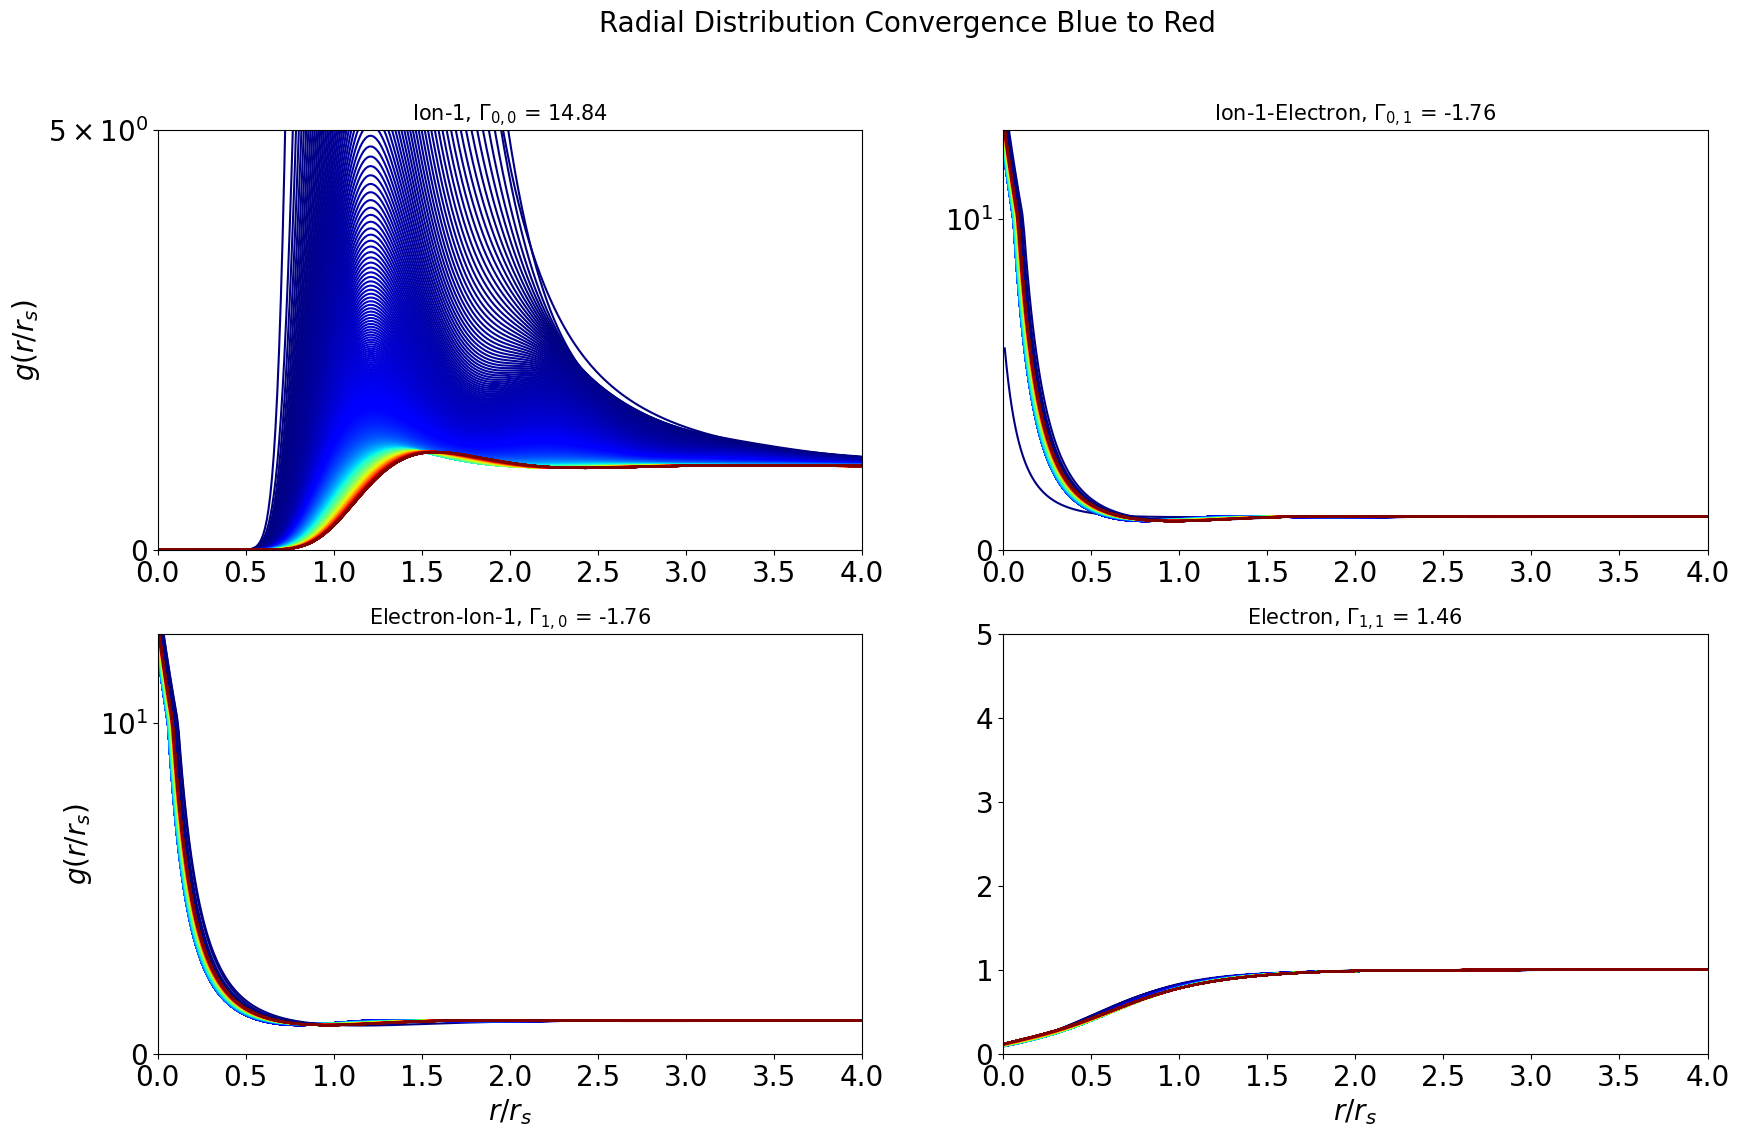

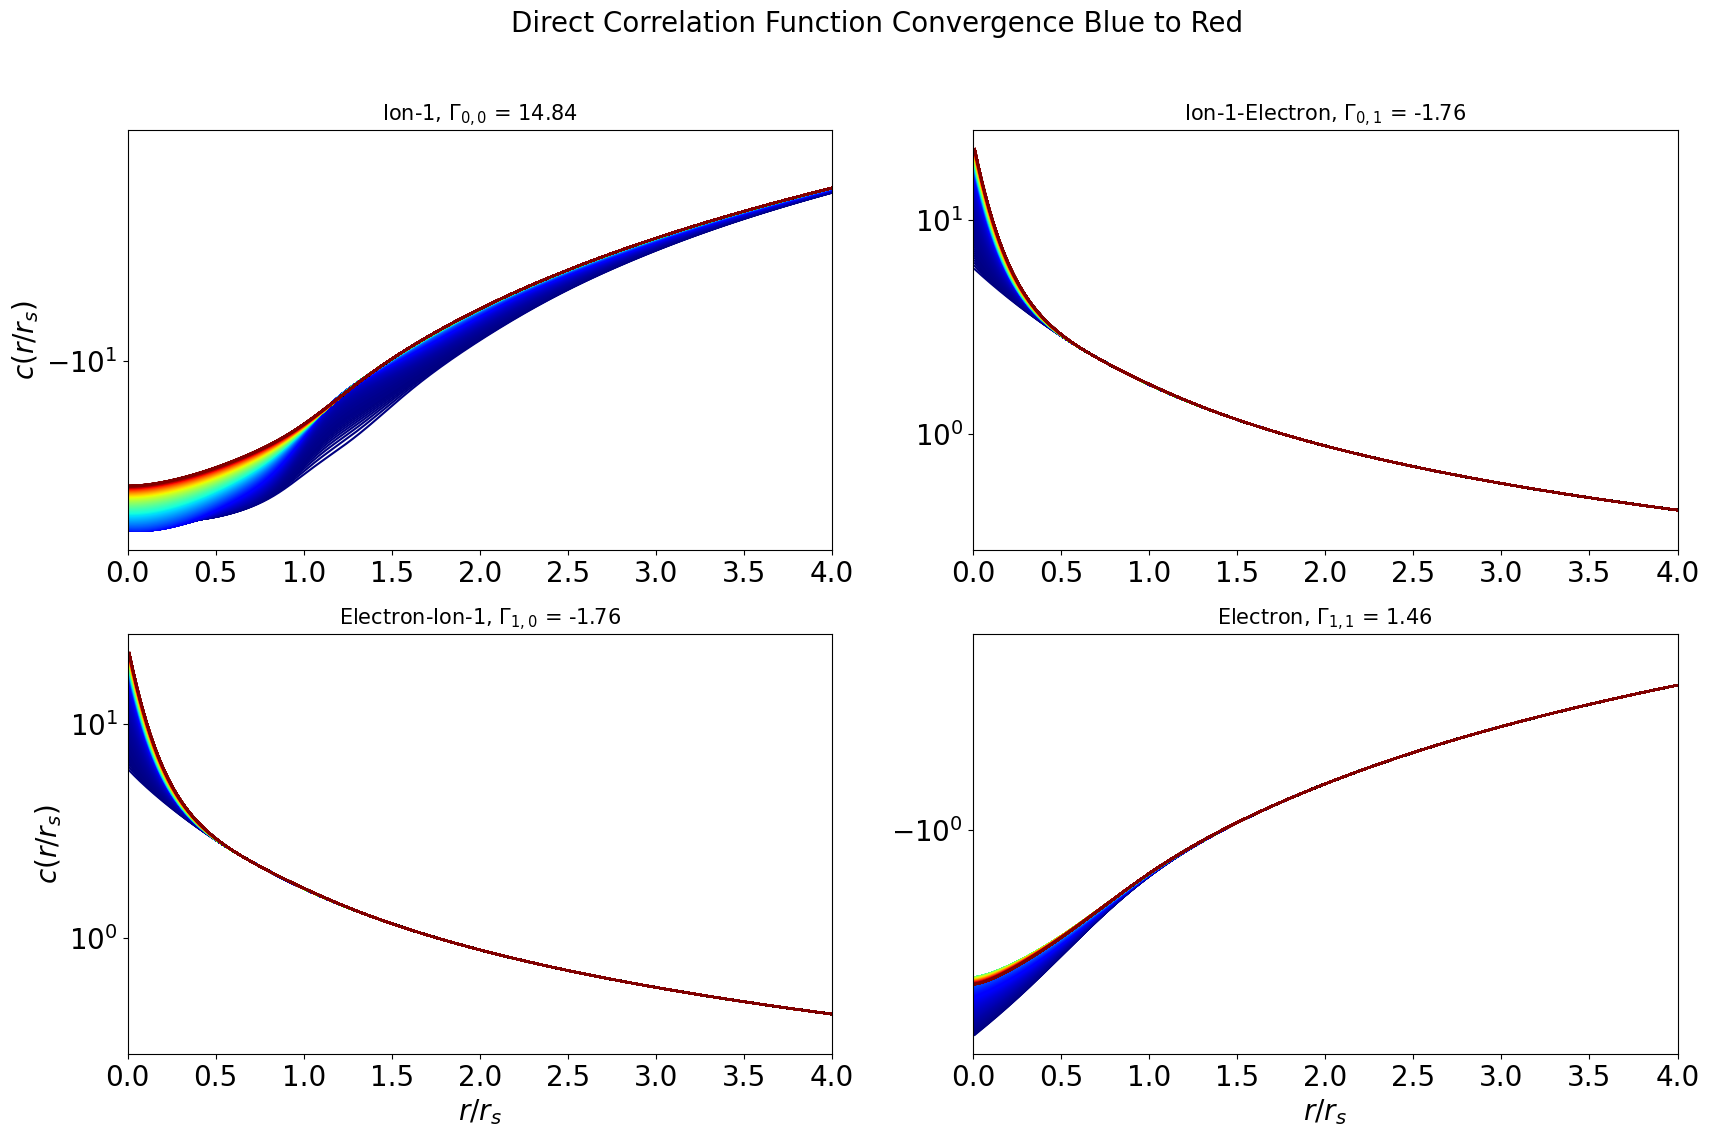

In [61]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

In [33]:
copper_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.1)

Λei = 0.295
Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 1.11e+01, OZ: 2.96e-01, HNC: 5.30e-02, tot: 9.97e+01, tot: 1.00e+02
1: Err in c_r: 1.00e+01, OZ: 2.91e-01, HNC: 4.17e-02, tot: 9.03e+01, tot: 9.08e+01
2: Err in c_r: 9.08e+00, OZ: 2.85e-01, HNC: 3.54e-02, tot: 8.17e+01, tot: 8.22e+01
3: Err in c_r: 8.22e+00, OZ: 2.80e-01, HNC: 3.12e-02, tot: 7.40e+01, tot: 7.44e+01
4: Err in c_r: 7.44e+00, OZ: 2.75e-01, HNC: 2.82e-02, tot: 6.70e+01, tot: 6.74e+01
5: Err in c_r: 6.74e+00, OZ: 2.70e-01, HNC: 2.60e-02, tot: 6.06e+01, tot: 6.10e+01
6: Err in c_r: 6.10e+00, OZ: 2.65e-01, HNC: 2.43e-02, tot: 5.49e+01, tot: 5.52e+01
7: Err in c_r: 5.52e+00, OZ: 2.61e-01, HNC: 2.30e-02, tot: 4.97e+01, tot: 4.99e+01
8: Err in c_r: 4.99e+00, OZ: 2.57e-01, HNC: 2.19e-02, tot: 4.49e+01, tot: 4.52e+01
9: Err in c_r: 4.52e+00, OZ: 2.52e-01, HNC: 2.11e-02, tot: 4.07e+01, tot: 4.09e+01
10: Err in c_r: 4.09e+00, OZ: 2.48e-01, HNC: 2.04e-02, tot: 3.68e+

105: Err in c_r: 1.53e-02, OZ: 5.14e-02, HNC: 5.20e-03, tot: 1.37e-01, tot: 8.94e-01
106: Err in c_r: 1.49e-02, OZ: 5.04e-02, HNC: 5.10e-03, tot: 1.34e-01, tot: 8.94e-01
107: Err in c_r: 1.45e-02, OZ: 4.94e-02, HNC: 5.01e-03, tot: 1.31e-01, tot: 8.93e-01
108: Err in c_r: 1.42e-02, OZ: 4.85e-02, HNC: 4.91e-03, tot: 1.28e-01, tot: 8.92e-01
109: Err in c_r: 1.39e-02, OZ: 4.75e-02, HNC: 4.82e-03, tot: 1.25e-01, tot: 8.91e-01
110: Err in c_r: 1.35e-02, OZ: 4.66e-02, HNC: 4.73e-03, tot: 1.22e-01, tot: 8.91e-01
111: Err in c_r: 1.32e-02, OZ: 4.57e-02, HNC: 4.64e-03, tot: 1.19e-01, tot: 8.90e-01
112: Err in c_r: 1.29e-02, OZ: 4.48e-02, HNC: 4.55e-03, tot: 1.16e-01, tot: 8.90e-01
113: Err in c_r: 1.26e-02, OZ: 4.40e-02, HNC: 4.46e-03, tot: 1.13e-01, tot: 8.89e-01
114: Err in c_r: 1.23e-02, OZ: 4.31e-02, HNC: 4.37e-03, tot: 1.11e-01, tot: 8.89e-01
115: Err in c_r: 1.20e-02, OZ: 4.23e-02, HNC: 4.29e-03, tot: 1.08e-01, tot: 8.88e-01
116: Err in c_r: 1.17e-02, OZ: 4.15e-02, HNC: 4.21e-03, tot: 1.06

213: Err in c_r: 1.41e-03, OZ: 5.81e-03, HNC: 5.88e-04, tot: 1.27e-02, tot: 8.74e-01
214: Err in c_r: 1.38e-03, OZ: 5.69e-03, HNC: 5.76e-04, tot: 1.24e-02, tot: 8.74e-01
215: Err in c_r: 1.35e-03, OZ: 5.57e-03, HNC: 5.64e-04, tot: 1.22e-02, tot: 8.74e-01
216: Err in c_r: 1.32e-03, OZ: 5.46e-03, HNC: 5.53e-04, tot: 1.19e-02, tot: 8.74e-01
217: Err in c_r: 1.30e-03, OZ: 5.35e-03, HNC: 5.41e-04, tot: 1.17e-02, tot: 8.74e-01
218: Err in c_r: 1.27e-03, OZ: 5.24e-03, HNC: 5.30e-04, tot: 1.14e-02, tot: 8.74e-01
219: Err in c_r: 1.24e-03, OZ: 5.13e-03, HNC: 5.20e-04, tot: 1.12e-02, tot: 8.74e-01
220: Err in c_r: 1.22e-03, OZ: 5.02e-03, HNC: 5.09e-04, tot: 1.10e-02, tot: 8.74e-01
221: Err in c_r: 1.19e-03, OZ: 4.92e-03, HNC: 4.98e-04, tot: 1.07e-02, tot: 8.74e-01
222: Err in c_r: 1.17e-03, OZ: 4.82e-03, HNC: 4.88e-04, tot: 1.05e-02, tot: 8.74e-01
223: Err in c_r: 1.14e-03, OZ: 4.72e-03, HNC: 4.78e-04, tot: 1.03e-02, tot: 8.74e-01
224: Err in c_r: 1.12e-03, OZ: 4.63e-03, HNC: 4.68e-04, tot: 1.01

314: Err in c_r: 1.70e-04, OZ: 7.15e-04, HNC: 7.24e-05, tot: 1.53e-03, tot: 8.73e-01
315: Err in c_r: 1.67e-04, OZ: 7.00e-04, HNC: 7.09e-05, tot: 1.50e-03, tot: 8.73e-01
316: Err in c_r: 1.63e-04, OZ: 6.86e-04, HNC: 6.94e-05, tot: 1.47e-03, tot: 8.73e-01
317: Err in c_r: 1.60e-04, OZ: 6.72e-04, HNC: 6.80e-05, tot: 1.44e-03, tot: 8.73e-01
318: Err in c_r: 1.57e-04, OZ: 6.58e-04, HNC: 6.66e-05, tot: 1.41e-03, tot: 8.73e-01
319: Err in c_r: 1.54e-04, OZ: 6.45e-04, HNC: 6.52e-05, tot: 1.38e-03, tot: 8.73e-01
320: Err in c_r: 1.50e-04, OZ: 6.31e-04, HNC: 6.39e-05, tot: 1.35e-03, tot: 8.73e-01
321: Err in c_r: 1.47e-04, OZ: 6.18e-04, HNC: 6.26e-05, tot: 1.33e-03, tot: 8.73e-01
322: Err in c_r: 1.44e-04, OZ: 6.06e-04, HNC: 6.13e-05, tot: 1.30e-03, tot: 8.73e-01
323: Err in c_r: 1.41e-04, OZ: 5.93e-04, HNC: 6.00e-05, tot: 1.27e-03, tot: 8.73e-01
324: Err in c_r: 1.38e-04, OZ: 5.81e-04, HNC: 5.88e-05, tot: 1.25e-03, tot: 8.73e-01
325: Err in c_r: 1.36e-04, OZ: 5.69e-04, HNC: 5.76e-05, tot: 1.22

416: Err in c_r: 2.04e-05, OZ: 8.58e-05, HNC: 8.68e-06, tot: 1.83e-04, tot: 8.73e-01
417: Err in c_r: 2.00e-05, OZ: 8.40e-05, HNC: 8.50e-06, tot: 1.80e-04, tot: 8.73e-01
418: Err in c_r: 1.96e-05, OZ: 8.23e-05, HNC: 8.32e-06, tot: 1.76e-04, tot: 8.73e-01
419: Err in c_r: 1.92e-05, OZ: 8.06e-05, HNC: 8.15e-06, tot: 1.72e-04, tot: 8.73e-01
420: Err in c_r: 1.88e-05, OZ: 7.89e-05, HNC: 7.98e-06, tot: 1.69e-04, tot: 8.73e-01
421: Err in c_r: 1.84e-05, OZ: 7.73e-05, HNC: 7.82e-06, tot: 1.65e-04, tot: 8.73e-01
422: Err in c_r: 1.80e-05, OZ: 7.57e-05, HNC: 7.66e-06, tot: 1.62e-04, tot: 8.73e-01
423: Err in c_r: 1.76e-05, OZ: 7.41e-05, HNC: 7.50e-06, tot: 1.59e-04, tot: 8.73e-01
424: Err in c_r: 1.73e-05, OZ: 7.26e-05, HNC: 7.35e-06, tot: 1.55e-04, tot: 8.73e-01
425: Err in c_r: 1.69e-05, OZ: 7.11e-05, HNC: 7.19e-06, tot: 1.52e-04, tot: 8.73e-01
426: Err in c_r: 1.66e-05, OZ: 6.96e-05, HNC: 7.05e-06, tot: 1.49e-04, tot: 8.73e-01
427: Err in c_r: 1.62e-05, OZ: 6.82e-05, HNC: 6.90e-06, tot: 1.46

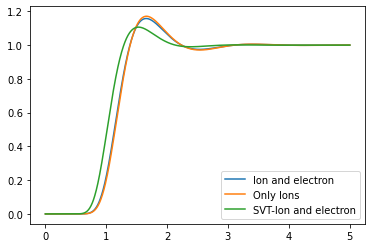

In [35]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.plot(copper.r_array, copperSVT.h_r_matrix[0,0]+1, label="SVT-Ion and electron")
ax.legend()



# Compare to Dharma Wardana (Not converging yet!)

In [9]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ri = 0.4473#qsp.rs_from_n(1.8e31*aB**3)
ni = QSP_HNC.n_from_rs(ri)/aB**3*1e-6
Te = 0.34*eV 
Ti   = 0.34*eV 
Z, A = 1, 1
Zstar= 1

hydrogen_DW, hydrogen_DW_qsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, method='fixed' ,alpha=5e-1)
hydrogen_DW_one_species, _ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3,method='fixed' ,alpha=1e-1)

TypeError: QSP_HNC.__init__() missing 1 required positional argument: 'ne'

In [18]:
hydrogen_DW_SVT, hydrogen_DW_qsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3,oz_type='SVT', method='fixed' ,alpha=5e-1)

Λei = 0.347
Λee = 0.491
Λei = 0.347
Γii=178.917, Γie=-0.338, Γee=0.338 
r_i=0.447
r_e=0.447
θ  =1.36e-03
0: Err in c_r: 2.92e+02, OZ: 1.76e-01, HNC: 1.14e-02, tot: 2.92e+02, tot: 3.29e+02
1: Err in c_r: 1.64e+02, OZ: 1.65e-01, HNC: 5.66e-03, tot: 1.64e+02, tot: 1.86e+02
2: Err in c_r: 9.29e+01, OZ: 1.58e-01, HNC: 1.00e-02, tot: 9.29e+01, tot: 1.07e+02
3: Err in c_r: 5.35e+01, OZ: 1.54e-01, HNC: 2.78e-01, tot: 5.35e+01, tot: 6.38e+01
4: Err in c_r: 3.19e+01, OZ: 1.54e-01, HNC: 3.07e+00, tot: 3.19e+01, tot: 4.00e+01
5: Err in c_r: 2.00e+01, OZ: 1.52e-01, HNC: 3.12e+00, tot: 2.00e+01, tot: 2.67e+01
6: Err in c_r: 1.33e+01, OZ: 1.53e-01, HNC: 9.22e+00, tot: 1.33e+01, tot: 1.91e+01
7: Err in c_r: 9.54e+00, OZ: 1.50e-01, HNC: 4.67e+00, tot: 9.54e+00, tot: 1.46e+01
8: Err in c_r: 7.29e+00, OZ: 1.53e-01, HNC: 1.25e+01, tot: 7.29e+00, tot: 1.17e+01
9: Err in c_r: 5.85e+00, OZ: 1.46e-01, HNC: 3.12e+00, tot: 5.85e+00, tot: 9.84e+00
10: Err in c_r: 4.91e+00, OZ: 1.51e-01, HNC: 9.40e+00, tot: 4.91e

97: Err in c_r: 1.50e-01, OZ: 5.27e-02, HNC: 5.37e-03, tot: 1.50e-01, tot: 5.95e-01
98: Err in c_r: 1.47e-01, OZ: 5.20e-02, HNC: 5.22e-03, tot: 1.47e-01, tot: 5.92e-01
99: Err in c_r: 1.44e-01, OZ: 5.13e-02, HNC: 5.08e-03, tot: 1.44e-01, tot: 5.88e-01
100: Err in c_r: 1.41e-01, OZ: 5.06e-02, HNC: 4.95e-03, tot: 1.41e-01, tot: 5.85e-01
101: Err in c_r: 1.38e-01, OZ: 4.99e-02, HNC: 4.82e-03, tot: 1.38e-01, tot: 5.82e-01
102: Err in c_r: 1.35e-01, OZ: 4.92e-02, HNC: 4.70e-03, tot: 1.35e-01, tot: 5.79e-01
103: Err in c_r: 1.33e-01, OZ: 4.86e-02, HNC: 4.58e-03, tot: 1.33e-01, tot: 5.77e-01
104: Err in c_r: 1.30e-01, OZ: 4.79e-02, HNC: 4.47e-03, tot: 1.30e-01, tot: 5.74e-01
105: Err in c_r: 1.27e-01, OZ: 4.73e-02, HNC: 4.36e-03, tot: 1.27e-01, tot: 5.71e-01
106: Err in c_r: 1.25e-01, OZ: 4.66e-02, HNC: 4.26e-03, tot: 1.25e-01, tot: 5.69e-01
107: Err in c_r: 1.22e-01, OZ: 4.60e-02, HNC: 4.16e-03, tot: 1.22e-01, tot: 5.66e-01
108: Err in c_r: 1.20e-01, OZ: 4.54e-02, HNC: 4.06e-03, tot: 1.20e-0

195: Err in c_r: 2.61e-02, OZ: 1.29e-02, HNC: 7.09e-04, tot: 2.61e-02, tot: 4.96e-01
196: Err in c_r: 2.56e-02, OZ: 1.27e-02, HNC: 6.97e-04, tot: 2.56e-02, tot: 4.96e-01
197: Err in c_r: 2.52e-02, OZ: 1.25e-02, HNC: 6.85e-04, tot: 2.52e-02, tot: 4.96e-01
198: Err in c_r: 2.47e-02, OZ: 1.23e-02, HNC: 6.73e-04, tot: 2.47e-02, tot: 4.96e-01
199: Err in c_r: 2.43e-02, OZ: 1.21e-02, HNC: 6.62e-04, tot: 2.43e-02, tot: 4.95e-01
200: Err in c_r: 2.39e-02, OZ: 1.19e-02, HNC: 6.50e-04, tot: 2.39e-02, tot: 4.95e-01
201: Err in c_r: 2.35e-02, OZ: 1.18e-02, HNC: 6.39e-04, tot: 2.35e-02, tot: 4.95e-01
202: Err in c_r: 2.30e-02, OZ: 1.16e-02, HNC: 6.28e-04, tot: 2.30e-02, tot: 4.95e-01
203: Err in c_r: 2.26e-02, OZ: 1.14e-02, HNC: 6.17e-04, tot: 2.26e-02, tot: 4.95e-01
204: Err in c_r: 2.22e-02, OZ: 1.12e-02, HNC: 6.06e-04, tot: 2.22e-02, tot: 4.95e-01
205: Err in c_r: 2.18e-02, OZ: 1.10e-02, HNC: 5.95e-04, tot: 2.18e-02, tot: 4.94e-01
206: Err in c_r: 2.15e-02, OZ: 1.09e-02, HNC: 5.85e-04, tot: 2.15

292: Err in c_r: 4.98e-03, OZ: 2.77e-03, HNC: 1.28e-04, tot: 4.98e-03, tot: 4.89e-01
293: Err in c_r: 4.90e-03, OZ: 2.72e-03, HNC: 1.26e-04, tot: 4.90e-03, tot: 4.89e-01
294: Err in c_r: 4.82e-03, OZ: 2.68e-03, HNC: 1.24e-04, tot: 4.82e-03, tot: 4.89e-01
295: Err in c_r: 4.74e-03, OZ: 2.64e-03, HNC: 1.21e-04, tot: 4.74e-03, tot: 4.89e-01
296: Err in c_r: 4.67e-03, OZ: 2.60e-03, HNC: 1.19e-04, tot: 4.67e-03, tot: 4.89e-01
297: Err in c_r: 4.59e-03, OZ: 2.56e-03, HNC: 1.17e-04, tot: 4.59e-03, tot: 4.89e-01
298: Err in c_r: 4.52e-03, OZ: 2.52e-03, HNC: 1.16e-04, tot: 4.52e-03, tot: 4.88e-01
299: Err in c_r: 4.45e-03, OZ: 2.48e-03, HNC: 1.14e-04, tot: 4.45e-03, tot: 4.88e-01
300: Err in c_r: 4.37e-03, OZ: 2.44e-03, HNC: 1.12e-04, tot: 4.37e-03, tot: 4.88e-01
301: Err in c_r: 4.30e-03, OZ: 2.40e-03, HNC: 1.10e-04, tot: 4.30e-03, tot: 4.88e-01
302: Err in c_r: 4.24e-03, OZ: 2.36e-03, HNC: 1.08e-04, tot: 4.24e-03, tot: 4.88e-01
303: Err in c_r: 4.17e-03, OZ: 2.33e-03, HNC: 1.06e-04, tot: 4.17

389: Err in c_r: 1.08e-03, OZ: 6.14e-04, HNC: 2.68e-05, tot: 1.08e-03, tot: 4.88e-01
390: Err in c_r: 1.06e-03, OZ: 6.05e-04, HNC: 2.64e-05, tot: 1.06e-03, tot: 4.88e-01
391: Err in c_r: 1.05e-03, OZ: 5.95e-04, HNC: 2.60e-05, tot: 1.05e-03, tot: 4.88e-01
392: Err in c_r: 1.03e-03, OZ: 5.86e-04, HNC: 2.56e-05, tot: 1.03e-03, tot: 4.88e-01
393: Err in c_r: 1.02e-03, OZ: 5.77e-04, HNC: 2.52e-05, tot: 1.02e-03, tot: 4.88e-01
394: Err in c_r: 1.00e-03, OZ: 5.69e-04, HNC: 2.48e-05, tot: 1.00e-03, tot: 4.88e-01
395: Err in c_r: 9.85e-04, OZ: 5.60e-04, HNC: 2.44e-05, tot: 9.85e-04, tot: 4.88e-01
396: Err in c_r: 9.70e-04, OZ: 5.51e-04, HNC: 2.41e-05, tot: 9.70e-04, tot: 4.88e-01
397: Err in c_r: 9.55e-04, OZ: 5.43e-04, HNC: 2.37e-05, tot: 9.55e-04, tot: 4.88e-01
398: Err in c_r: 9.40e-04, OZ: 5.35e-04, HNC: 2.33e-05, tot: 9.40e-04, tot: 4.88e-01
399: Err in c_r: 9.26e-04, OZ: 5.27e-04, HNC: 2.30e-05, tot: 9.26e-04, tot: 4.88e-01
400: Err in c_r: 9.12e-04, OZ: 5.18e-04, HNC: 2.26e-05, tot: 9.12

487: Err in c_r: 2.39e-04, OZ: 1.37e-04, HNC: 5.90e-06, tot: 2.39e-04, tot: 4.88e-01
488: Err in c_r: 2.36e-04, OZ: 1.35e-04, HNC: 5.81e-06, tot: 2.36e-04, tot: 4.88e-01
489: Err in c_r: 2.32e-04, OZ: 1.33e-04, HNC: 5.72e-06, tot: 2.32e-04, tot: 4.88e-01
490: Err in c_r: 2.29e-04, OZ: 1.31e-04, HNC: 5.63e-06, tot: 2.29e-04, tot: 4.88e-01
491: Err in c_r: 2.25e-04, OZ: 1.29e-04, HNC: 5.54e-06, tot: 2.25e-04, tot: 4.88e-01
492: Err in c_r: 2.22e-04, OZ: 1.27e-04, HNC: 5.46e-06, tot: 2.22e-04, tot: 4.88e-01
493: Err in c_r: 2.18e-04, OZ: 1.25e-04, HNC: 5.38e-06, tot: 2.18e-04, tot: 4.88e-01
494: Err in c_r: 2.15e-04, OZ: 1.23e-04, HNC: 5.29e-06, tot: 2.15e-04, tot: 4.88e-01
495: Err in c_r: 2.12e-04, OZ: 1.21e-04, HNC: 5.21e-06, tot: 2.12e-04, tot: 4.88e-01
496: Err in c_r: 2.09e-04, OZ: 1.19e-04, HNC: 5.13e-06, tot: 2.09e-04, tot: 4.88e-01
497: Err in c_r: 2.05e-04, OZ: 1.17e-04, HNC: 5.06e-06, tot: 2.05e-04, tot: 4.88e-01
498: Err in c_r: 2.02e-04, OZ: 1.15e-04, HNC: 4.98e-06, tot: 2.02

585: Err in c_r: 5.35e-05, OZ: 3.05e-05, HNC: 1.31e-06, tot: 5.35e-05, tot: 4.88e-01
586: Err in c_r: 5.26e-05, OZ: 3.01e-05, HNC: 1.29e-06, tot: 5.26e-05, tot: 4.88e-01
587: Err in c_r: 5.18e-05, OZ: 2.96e-05, HNC: 1.27e-06, tot: 5.18e-05, tot: 4.88e-01
588: Err in c_r: 5.11e-05, OZ: 2.92e-05, HNC: 1.26e-06, tot: 5.11e-05, tot: 4.88e-01
589: Err in c_r: 5.03e-05, OZ: 2.87e-05, HNC: 1.24e-06, tot: 5.03e-05, tot: 4.88e-01
590: Err in c_r: 4.95e-05, OZ: 2.83e-05, HNC: 1.22e-06, tot: 4.95e-05, tot: 4.88e-01
591: Err in c_r: 4.88e-05, OZ: 2.79e-05, HNC: 1.20e-06, tot: 4.88e-05, tot: 4.88e-01
592: Err in c_r: 4.80e-05, OZ: 2.74e-05, HNC: 1.18e-06, tot: 4.80e-05, tot: 4.88e-01
593: Err in c_r: 4.73e-05, OZ: 2.70e-05, HNC: 1.16e-06, tot: 4.73e-05, tot: 4.88e-01
594: Err in c_r: 4.66e-05, OZ: 2.66e-05, HNC: 1.15e-06, tot: 4.66e-05, tot: 4.88e-01
595: Err in c_r: 4.59e-05, OZ: 2.62e-05, HNC: 1.13e-06, tot: 4.59e-05, tot: 4.88e-01
596: Err in c_r: 4.52e-05, OZ: 2.58e-05, HNC: 1.11e-06, tot: 4.52

682: Err in c_r: 1.21e-05, OZ: 6.94e-06, HNC: 2.98e-07, tot: 1.21e-05, tot: 4.88e-01
683: Err in c_r: 1.20e-05, OZ: 6.83e-06, HNC: 2.94e-07, tot: 1.20e-05, tot: 4.88e-01
684: Err in c_r: 1.18e-05, OZ: 6.73e-06, HNC: 2.89e-07, tot: 1.18e-05, tot: 4.88e-01
685: Err in c_r: 1.16e-05, OZ: 6.63e-06, HNC: 2.85e-07, tot: 1.16e-05, tot: 4.88e-01
686: Err in c_r: 1.14e-05, OZ: 6.53e-06, HNC: 2.81e-07, tot: 1.14e-05, tot: 4.88e-01
687: Err in c_r: 1.12e-05, OZ: 6.43e-06, HNC: 2.76e-07, tot: 1.12e-05, tot: 4.88e-01
688: Err in c_r: 1.11e-05, OZ: 6.33e-06, HNC: 2.72e-07, tot: 1.11e-05, tot: 4.88e-01
689: Err in c_r: 1.09e-05, OZ: 6.24e-06, HNC: 2.68e-07, tot: 1.09e-05, tot: 4.88e-01
690: Err in c_r: 1.07e-05, OZ: 6.14e-06, HNC: 2.64e-07, tot: 1.07e-05, tot: 4.88e-01
691: Err in c_r: 1.06e-05, OZ: 6.05e-06, HNC: 2.60e-07, tot: 1.06e-05, tot: 4.88e-01
692: Err in c_r: 1.04e-05, OZ: 5.96e-06, HNC: 2.56e-07, tot: 1.04e-05, tot: 4.88e-01
693: Err in c_r: 1.03e-05, OZ: 5.87e-06, HNC: 2.52e-07, tot: 1.03

779: Err in c_r: 2.76e-06, OZ: 1.58e-06, HNC: 6.78e-08, tot: 2.76e-06, tot: 4.88e-01
780: Err in c_r: 2.72e-06, OZ: 1.55e-06, HNC: 6.68e-08, tot: 2.72e-06, tot: 4.88e-01
781: Err in c_r: 2.68e-06, OZ: 1.53e-06, HNC: 6.58e-08, tot: 2.68e-06, tot: 4.88e-01
782: Err in c_r: 2.64e-06, OZ: 1.51e-06, HNC: 6.48e-08, tot: 2.64e-06, tot: 4.88e-01
783: Err in c_r: 2.60e-06, OZ: 1.48e-06, HNC: 6.38e-08, tot: 2.60e-06, tot: 4.88e-01
784: Err in c_r: 2.56e-06, OZ: 1.46e-06, HNC: 6.28e-08, tot: 2.56e-06, tot: 4.88e-01
785: Err in c_r: 2.52e-06, OZ: 1.44e-06, HNC: 6.19e-08, tot: 2.52e-06, tot: 4.88e-01
786: Err in c_r: 2.48e-06, OZ: 1.42e-06, HNC: 6.09e-08, tot: 2.48e-06, tot: 4.88e-01
787: Err in c_r: 2.44e-06, OZ: 1.40e-06, HNC: 6.00e-08, tot: 2.44e-06, tot: 4.88e-01
788: Err in c_r: 2.40e-06, OZ: 1.37e-06, HNC: 5.91e-08, tot: 2.40e-06, tot: 4.88e-01
789: Err in c_r: 2.37e-06, OZ: 1.35e-06, HNC: 5.82e-08, tot: 2.37e-06, tot: 4.88e-01
790: Err in c_r: 2.33e-06, OZ: 1.33e-06, HNC: 5.73e-08, tot: 2.33

877: Err in c_r: 6.18e-07, OZ: 3.53e-07, HNC: 1.52e-08, tot: 6.18e-07, tot: 4.88e-01
878: Err in c_r: 6.08e-07, OZ: 3.48e-07, HNC: 1.49e-08, tot: 6.08e-07, tot: 4.88e-01
879: Err in c_r: 5.99e-07, OZ: 3.42e-07, HNC: 1.47e-08, tot: 5.99e-07, tot: 4.88e-01
880: Err in c_r: 5.90e-07, OZ: 3.37e-07, HNC: 1.45e-08, tot: 5.90e-07, tot: 4.88e-01
881: Err in c_r: 5.81e-07, OZ: 3.32e-07, HNC: 1.43e-08, tot: 5.81e-07, tot: 4.88e-01
882: Err in c_r: 5.72e-07, OZ: 3.27e-07, HNC: 1.41e-08, tot: 5.72e-07, tot: 4.88e-01
883: Err in c_r: 5.63e-07, OZ: 3.22e-07, HNC: 1.38e-08, tot: 5.63e-07, tot: 4.88e-01
884: Err in c_r: 5.55e-07, OZ: 3.17e-07, HNC: 1.36e-08, tot: 5.55e-07, tot: 4.88e-01
885: Err in c_r: 5.46e-07, OZ: 3.12e-07, HNC: 1.34e-08, tot: 5.46e-07, tot: 4.88e-01
886: Err in c_r: 5.38e-07, OZ: 3.08e-07, HNC: 1.32e-08, tot: 5.38e-07, tot: 4.88e-01
887: Err in c_r: 5.30e-07, OZ: 3.03e-07, HNC: 1.30e-08, tot: 5.30e-07, tot: 4.88e-01
888: Err in c_r: 5.22e-07, OZ: 2.98e-07, HNC: 1.28e-08, tot: 5.22

974: Err in c_r: 1.40e-07, OZ: 8.02e-08, HNC: 3.45e-09, tot: 1.40e-07, tot: 4.88e-01
975: Err in c_r: 1.38e-07, OZ: 7.90e-08, HNC: 3.40e-09, tot: 1.38e-07, tot: 4.88e-01
976: Err in c_r: 1.36e-07, OZ: 7.78e-08, HNC: 3.34e-09, tot: 1.36e-07, tot: 4.88e-01
977: Err in c_r: 1.34e-07, OZ: 7.66e-08, HNC: 3.30e-09, tot: 1.34e-07, tot: 4.88e-01
978: Err in c_r: 1.32e-07, OZ: 7.55e-08, HNC: 3.24e-09, tot: 1.32e-07, tot: 4.88e-01
979: Err in c_r: 1.30e-07, OZ: 7.43e-08, HNC: 3.19e-09, tot: 1.30e-07, tot: 4.88e-01
980: Err in c_r: 1.28e-07, OZ: 7.32e-08, HNC: 3.14e-09, tot: 1.28e-07, tot: 4.88e-01
981: Err in c_r: 1.26e-07, OZ: 7.21e-08, HNC: 3.10e-09, tot: 1.26e-07, tot: 4.88e-01
982: Err in c_r: 1.24e-07, OZ: 7.10e-08, HNC: 3.05e-09, tot: 1.24e-07, tot: 4.88e-01
983: Err in c_r: 1.22e-07, OZ: 6.99e-08, HNC: 3.01e-09, tot: 1.22e-07, tot: 4.88e-01
984: Err in c_r: 1.20e-07, OZ: 6.89e-08, HNC: 2.96e-09, tot: 1.20e-07, tot: 4.88e-01
985: Err in c_r: 1.19e-07, OZ: 6.78e-08, HNC: 2.91e-09, tot: 1.19

In [20]:
κ = get_κ(Zstar, ri, Ti, hydrogenqsp.E_F)

κ = get_κ(Zstar, ri, hydrogenqsp.Te_c, hydrogenqsp.E_F)
print("κ= ", κ)
hydrogen_TF, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=κ, which_Tij='geometric', method='fixed',
                            alpha=1e-1, num_iterations=1e3)

NameError: name 'hydrogenqsp' is not defined

In [ ]:
fake_κ=0.1
hydrogen_TF_fake, _ = run_hnc_TF(ni, Te, Z, A, Zstar ,κ=fake_κ, which_Tij='geometric', 
                               method='fixed', alpha=1e-1, num_iterations=1e3)

In [22]:
folder="./HNC_Agrees_with_DharmaWardana_Hydrogen/"
data_files=[folder+'DW_gee.txt',folder+'DW_gei.txt',folder+'DW_gii.txt']
labels=['gee','gei','gii']

In [ ]:
hydrogen_DW.plot_species_convergence_g(n_slices= int(len(hydrogen_DW.h_list)/1)  )

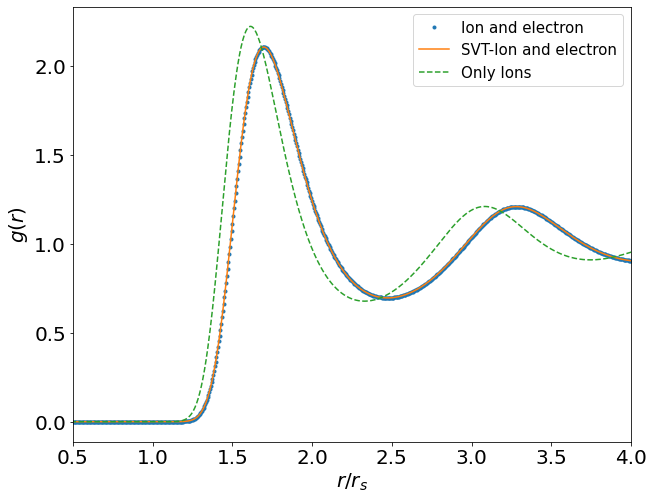

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(hydrogen_DW.r_array, hydrogen_DW.h_r_matrix[0,0]+1,'.', label='Ion and electron')
ax.plot(hydrogen_DW_SVT.r_array, hydrogen_DW.h_r_matrix[0,0]+1,'', label='SVT-Ion and electron')
ax.plot(hydrogen_DW_one_species.r_array, hydrogen_DW_one_species.h_r_matrix[0,0]+1, '--',label="Only Ions")

# ax.plot(hydrogen_TF.r_array, hydrogen_TF.h_r_matrix[0,0]+1,'k.',label='TF, Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, κ))
# ax.plot(hydrogen_TF_fake.r_array, hydrogen_TF_fake.h_r_matrix[0,0]+1,'k--',label='TF (fake), Γ={0:.2f}, κ={1:.2f}'.format(carbonqsp.Γii, fake_κ))


ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


In [125]:
hydrogen_DW_qsp.Γei

-0.3384387646638051